In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import re
import time
import cv2
import random
import math
from keras.datasets import mnist

Using TensorFlow backend.
D:\Conda\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Conda\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Conda\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Conda\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym o

In [3]:
(trainX, trainy), (testX, testy) = mnist.load_data()

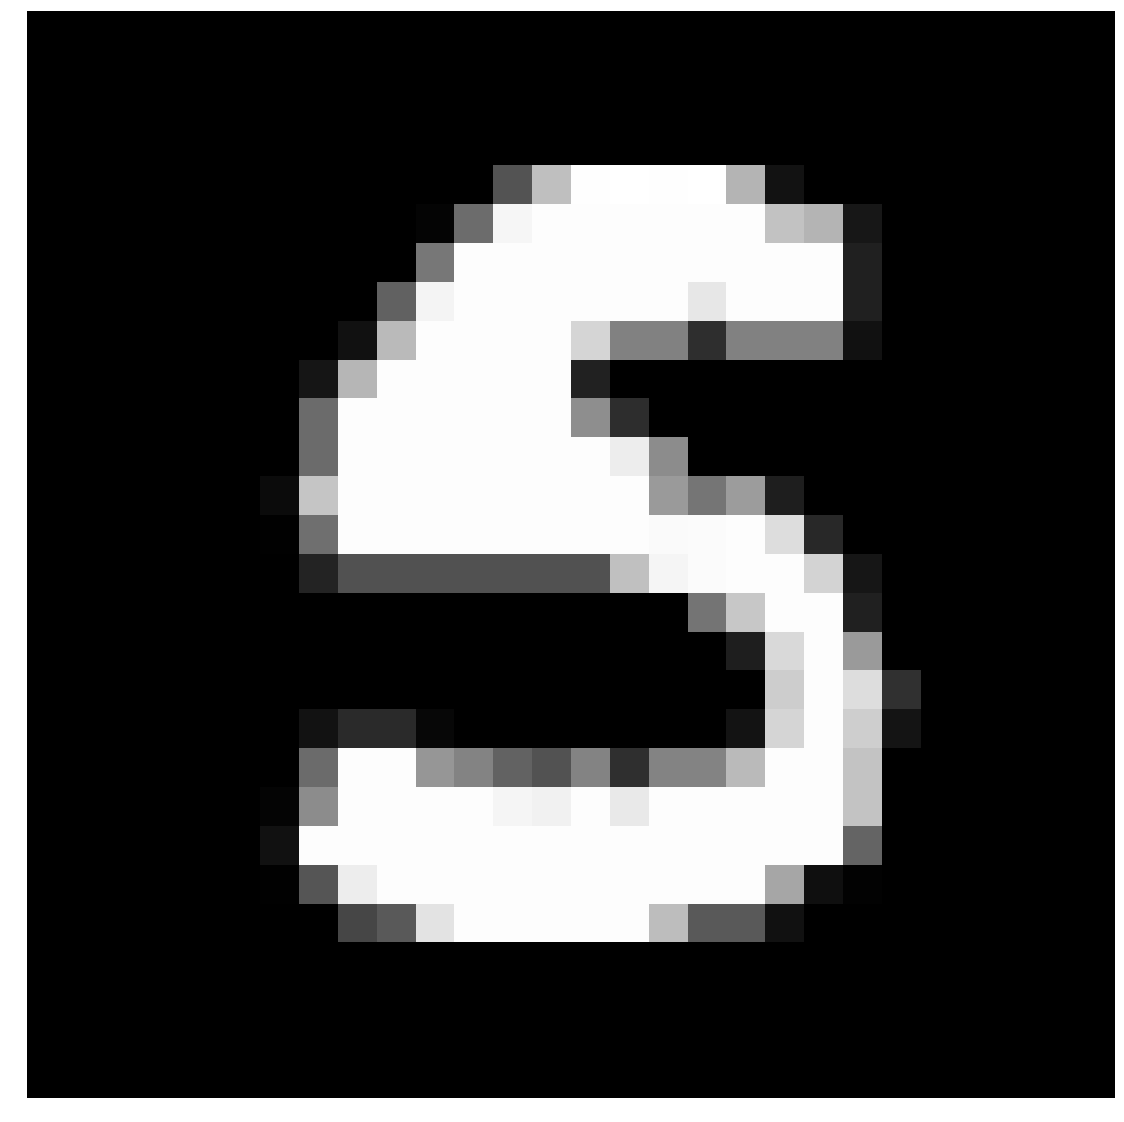

In [57]:
def disp(X):
    fig, ax=plt.subplots(1,1,figsize=(20,20))
    ax.imshow(X)
    ax.axis('off')
    plt.show()

zz=trainX[1997]
zz=zz.reshape(zz.shape[0], zz.shape[1], 1)
zz1=zz.copy()

zz=np.append(zz, zz1, axis=2)
zz=np.append(zz, zz1, axis=2)
zz=zz/255
disp(zz)
#print(zz.dtype, type(zz))

In [39]:
#Tworzę większą tablicę zer i "wkładam" w nią X - array
def my_pad(X, a, b, c, d):    
    Y=np.asarray([0.0]*(X.shape[0]+b+d)*(X.shape[1]+a+c)*X.shape[2]).reshape(X.shape[0]+b+d, X.shape[1]+a+c, X.shape[2])
    Y[b:X.shape[0]+b,a:X.shape[1]+a,:]=X
    return Y

def conv_forw(X, mat):
    Z=np.ndarray((X.shape[0]-mat.shape[0]+1, X.shape[1]-mat.shape[1]+1, X.shape[2]), dtype='int64')
    Z=Z*0
    s=str(X.dtype)
    
    a=(re.search('float', s)==None)
    b=(re.search('int', s)==None)
    if (a==False):
        X=X.astype('float64')
    else:
        X=X.astype('int64')
    
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ff=mat[i,j]*X
            ff=ff[i:X.shape[0]-mat.shape[0]+i+1,j:X.shape[1]-mat.shape[1]+j+1]
            Z=Z+ff
    return Z

def conv_back(X, mat, Der):
    Z=np.ndarray((X.shape[0], X.shape[1], X.shape[2]), dtype='float64')
    matd=mat*0
    Z=Z*0
    
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ff=mat[i,j]*Der
            #print('FFF', ff)
            Z[i:Der.shape[0]+i,j:Der.shape[1]+j]=Z[i:Der.shape[0]+i,j:Der.shape[1]+j]+ff
    
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ff=mat[i,j]*X
            ff=ff[i:X.shape[0]-mat.shape[0]+i+1,j:X.shape[1]-mat.shape[1]+j+1]
            matd[i,j]=sum(sum(sum(np.multiply(ff, Der))))
    
    return (Z, matd)

def relu(X):
    Y=X.copy()
    Y[Y<0]=0
    return Y

def relu_back(X, Der):
    Sd=Der.copy()
    Sd[X<0.0000001]=0
    return Sd

def pool_forw(X, mat):
    t1=(mat[0]-X.shape[0]%mat[0])%mat[0]
    t2=(mat[1]-X.shape[1]%mat[1])%mat[1]
    
    Y=my_pad(X, t2//2, t1//2, (t2//2+t2%2), t1//2+t1%2)
    silver_in_blood=np.asarray([[0]*(Y.shape[1]//mat[1])]*(Y.shape[0]//mat[0]))
    
    f1=pd.Series([True]*Y.shape[0])
    f2=pd.Series([True]*Y.shape[1])
    Exit=np.asarray(Y*0)
    Exit=Exit[:(Exit.shape[0]//mat[0]),:(Exit.shape[1]//mat[1])]
    
    Truth=np.asarray(Y*0).astype('int64')
    Truth2=np.asarray(Y*0).astype('int64')
    Pure=np.asarray(Y*0)
    Truth=Truth[:(Truth.shape[0]//mat[0]),:(Truth.shape[1]//mat[1])]
    Truth2=Truth2[:(Truth2.shape[0]//mat[0]),:(Truth2.shape[1]//mat[1])]
    
    for i in range(mat[0]):
        for j in range(mat[1]):
            Bleeding_One=Y[(f1.index%mat[0])==i][:,(f2.index%mat[1])==j]
            Truth[Exit<Bleeding_One]=i
            Truth2[Exit<Bleeding_One]=j
            Exit[Exit<Bleeding_One]=Bleeding_One[Exit<Bleeding_One]
    
    for i in range(Truth.shape[0]):
        for j in range(Truth.shape[1]):
            for ij in range(Truth.shape[2]):
                Pure[i*mat[0]+Truth[i,j,ij],j*mat[1]+Truth2[i,j,ij],ij]=1
    return (Exit, Pure)

def pool_back(X, mat, dim):
    Y=np.ndarray((X.shape[0]*mat[0], X.shape[1]*mat[1], X.shape[2]), dtype='float64')
    f1=pd.Series([1]*Y.shape[0])
    f2=pd.Series([1]*Y.shape[1])
    
    for i in range(mat[0]):
        for j in range(mat[1]):
            Y[np.ix_(np.asarray(f1[(f1.index%mat[0])==i].index),np.asarray(f2[(f2.index%mat[1])==j].index))]=X
    Y=Y*dim
    return Y

def dense_forw(W, L):
    return W*L

def dense_back(W, X, Der, cn):
    s1=cn*(Der*X)
    s2=cn*(W.T*x)
    return (s1, s2)

def sigmoid(x):
    try:
        s=1/(1+math.exp(-x))
        return s
    except:
        return 0

def sigmoid_forw(v):
    return np.asmatrix(np.apply_along_axis(sigmoid, 1, v).reshape(v.shape[0], 1))

def sigmoid_back(v):
    return np.asmatrix(np.apply_along_axis(lambda x: sigmoid(x)*(1-sigmoid(x)), 1, v).reshape(v.shape[0], 1))

def cost(act, pred):
    summ=0
    der=pred*0
    for i in range(pred.shape[0]):
        summ=summ-act[i,0]*math.log(pred[i,0])-(1-act[i,0])*math.log(1-pred[i,0])
        
        if ((pred[i,0]==0 and act[i,0]==0) or (pred[i,0]==1 and act[i,0]==1)):
            der[i,0]=0
        else:
            if (pred[i,0]<0.0000001):
                pred[i,0]=0.0000001
            elif(pred[i,0]>0.999999):
                pred[i,0]=0.999999
            der[i,0]=-act[i,0]/pred[i,0]+(1-act[i,0])/(1-pred[i,0])
        
    return (der, summ)

ccn=0.0005
streetcleaner=1690

matt=[0]*10
matt2=[0]*10
for i in range(10):
    matt[i]=np.asarray([np.random.normal(0, 0.4) for j in range(9)]).reshape(3,3)
    matt2[i]=np.asarray([np.random.normal(0, 0.4) for j in range(9)]).reshape(3,3)

#img=cv2.imread("E:\W3\GGHard.jpg")
w1=np.asmatrix(np.asarray([np.random.normal(0, 0.4) for j in range(streetcleaner*20)]).reshape(20,streetcleaner))
w2=np.asmatrix(np.asarray([np.random.normal(0, 0.4) for j in range(10*20)]).reshape(10,20))

loopz=30000

sk=[0]*loopz
t1=time.time()
for jj in range(loopz):
    img=trainX[jj]
    img=img/255
    img=img.reshape(img.shape[0], img.shape[1], 1)
    """img1=img.copy()
    img=np.append(img, img1, axis=2)
    img=np.append(img, img1, axis=2)"""

    m2=[0]*10
    m3=[0]*10
    m4=[0]*10
    m5=[0]*10
    m6=[0]*10
    m7=[0]*10
    m8=[0]*10
    #Forw - Konwolucja, Relu, Pooling
    for i in range(10):
        m2[i]=conv_forw(img, matt[i])
        m3[i]=relu(m2[i])
        m4[i], Face1=pool_forw(m3[i], (2,2))
        m8[i]=m4[i].reshape(m4[i].shape[0]*m4[i].shape[1]*m4[i].shape[2])
    
    """#Forw - Konwolucja, Relu, Pooling
    for i in range(10):
        m5[i]=conv_forw(m4[i], matt2[i]) 
        m6[i]=relu(m5[i])
        m7[i], Face2=pool_forw(m6[i], (2,2))
        m8[i]=m7[i].reshape(m7[i].shape[0]*m7[i].shape[1]*m7[i].shape[2])"""


    #Forw - 2*FC na macierzach
    kk=np.asarray(m8)
    m9=np.asmatrix(kk.reshape(kk.shape[0]*kk.shape[1], 1))
    #print(len(m9))

    s1=w1*m9
    s2=sigmoid_forw(s1)
    s3=w2*s2
    s4=sigmoid_forw(s3)

    #Koszt
    dp=np.asarray([0]*10).reshape(10, 1)
    dp[trainy[jj],0]=1
    der, suma=cost(dp, s4)
    sk[jj]=suma
    print(suma)

    #Back - 2.FC
    dk2=np.asmatrix(np.asarray(sigmoid_back(s3))*np.asarray(der))
    weight_delta2=dk2*s2.T
    dk1=w2.T*dk2

    #Back - 1.FC
    dk1=np.asmatrix(np.asarray(sigmoid_back(s1))*np.asarray(dk1))
    weight_delta1=dk1*m9.T
    dk0=w1.T*dk1

    #Back - 2*Konw, RElu, Pooling
    #dkl=np.asarray(dk0).reshape(10, m7[0].shape[0], m7[0].shape[1], m7[0].shape[2])
    dkl=np.asarray(dk0).reshape(10, m4[0].shape[0], m4[0].shape[1], m4[0].shape[2])
    
    mtb2=[0]*10
    mtb3=[0]*10
    mtb4=[0]*10
    mtb5=[0]*10
    mtb6=[0]*10
    mtb7=[0]*10
    mtb8=[0]*10
    """for i in range(10):
        mtb8[i]=pool_back(dkl[i], (2,2), Face2)
        cz=m6[i].shape
        nw=mtb8[i].shape
        mtb8[i]=mtb8[i][(nw[0]-cz[0])//2:cz[0]+(nw[0]-cz[0])//2, (nw[1]-cz[1])//2:cz[1]+(nw[1]-cz[1])//2]
        #print(m6[i].shape, mtb8[i].shape)
        mtb7[i]=relu_back(m6[i], mtb8[i])
        mtb6[i], Dr2=conv_back(m4[i], matt2[i], mtb7[i])"""

    for i in range(10):
        #mtb5[i]=pool_back(mtb6[i], (2,2), Face1)
        mtb5[i]=pool_back(dkl[i], (2,2), Face1)
        cz=m3[i].shape
        nw=mtb5[i].shape
        mtb5[i]=mtb5[i][(nw[0]-cz[0])//2:cz[0]+(nw[0]-cz[0])//2, (nw[1]-cz[1])//2:cz[1]+(nw[1]-cz[1])//2]
        mtb4[i]=relu_back(m3[i], mtb5[i])
        mtb3[i], Dr=conv_back(img, matt[i], mtb4[i])

    w1-=weight_delta1*ccn
    w2-=weight_delta2*ccn
    matt-=Dr*ccn
    matt2-=Dr2*ccn

t2=time.time()
print(t2-t1)
print(s4)

9.940440953996138
9.590467014395275
9.509733360098373
12.915699247315882
9.481399096185413
10.674912355835566
12.074855874905644
9.847846350616251
11.372943381069012
10.78914744436873
9.129222923614908
9.914818508811111
9.999838775451831
8.589086190087077
11.372043996864104
9.076663038365153
9.348949097594357
10.42792901221501
10.4601771075575
9.237263838479048
9.584383315385624
8.66330295555524
9.485606249537502
12.863949818102743
11.388296570002035
10.951739112008333
8.452337379674656
9.000078674077637
12.158138263351889
11.032263687003608
8.077744032353717
9.94000259527609
9.387154861959688
9.740180330987867
10.697428686198627
8.466298449885196
10.612114383172706
10.25561622231885
11.118066643947781
8.720205781213956
10.839925303071027
10.858734103122991
9.0527408898401
8.248689037947084
9.487833973804907
9.407162234749174
10.750139922504516
9.407629403985085
8.462859554022275
8.312124695198603
8.300060380350594
8.282895098807675
10.584276857239793
8.925354075302291
10.3648657671532

6.107694670274057
5.726626703647617
6.13679674617694
5.873473837498009
8.626703735491137
4.920721871741964
5.987725533510913
4.757288177050835
6.150665940783065
7.547774455072418
6.37055336431564
5.455725070199677
7.456822340445581
7.816331074414642
6.239240914048163
7.907915380081287
4.961251784872681
5.5567536969027405
7.811625111670697
7.352374984616435
6.138812046098073
7.876395350436675
5.34137924792049
6.376747543949797
6.95311252480022
6.342551044108533
6.425660990708655
6.781019273405619
6.734686607125763
5.93629137039742
5.747792272845715
5.985888514881885
4.390421843607577
4.977369063744881
7.9903464005732445
8.081246951899878
6.648437642921678
5.1823789954883015
5.180605229141859
4.8843205794525435
7.462489506113938
6.814158496165096
7.073281636551257
6.452216071747111
5.578368944148949
7.028757759513018
5.724187087969674
6.71765787088696
6.493647205426757
5.304781187294672
7.683986833397345
7.754831514015753
4.823759029871679
8.647647907018245
6.309951957024864
6.0629658747

3.6086416746436427
3.592768786468219
3.812057031450584
5.263367281308627
6.383347291827162
5.776345108893483
3.936798496704073
5.258725837630993
4.542005143390822
4.959660146865059
4.37079572577848
5.190105805975593
4.28110089900599
5.378110664662788
5.250902601962442
4.408019161813489
4.441472574799457
3.854059467813394
4.034427095098931
5.722854861867363
4.441225550118263
5.739393327748664
4.990134109918274
4.697063823812111
3.348481504260131
4.350120630722263
6.237258461342667
4.19917603220996
3.8350805048315766
4.830433601784166
4.278024553737459
4.130373448005462
3.74400774033828
4.8156698790196595
3.9530671353370863
4.686126265160315
6.413639740186159
4.030107359999524
4.4602249967220855
4.503900064392641
3.698598140324401
4.74559056399438
4.103750727105186
3.9527593696876497
5.617612506614401
4.104972738183058
6.3909633687016845
4.985236869010431
3.838933170083839
4.748806895117365
3.9215892095879985
5.698608132955409
4.864280836940511
5.840564220891997
4.701620167821432
4.67913

3.583620167121872
3.799548106304329
4.901515810588331
3.4889020399722686
3.5053310981741284
3.0386822963378197
3.146385807484575
6.595817504467814
3.6671910241784618
3.3593066675961554
3.869379181317905
4.344113711859561
3.5553839077865317
3.9851480318949934
4.141517937602959
4.355854694939203
3.7995386761238015
3.8745457209770104
4.320010921986938
3.123174254181147
3.638829897171435
3.5943149422460268
2.957412232016845
6.792019510421994
4.5118995565436055
3.791968580462548
4.065343851936145
4.754059506714276
5.425752734448079
3.5418743029231665
5.484135625538536
4.707586040917455
3.6142745675201313
5.399287700066068
3.7491854214351052
3.5892772531160837
3.175801645562025
3.944317626858316
5.039561113904713
4.166598989727067
3.540717689051902
5.408833959487342
3.440642009404555
3.84201237456295
3.793402672861158
3.8881690583793462
2.800681914812201
4.059827905665424
4.52900701031795
4.349034745683949
4.274941534825679
2.770985906800414
3.216568021258685
4.252244253329635
3.694516554828

3.2589828085386188
3.1646425632049633
3.323669986816236
4.221872100967507
3.0913813697069346
2.9632804440724896
3.9162012755128583
3.271491736639846
4.309146237591636
2.498773125931164
3.0569162053880237
3.0291646207118035
4.983306656516903
4.3905532737190045
3.9937078416277485
3.151505297328243
3.8396374341032464
3.3737408079955093
3.2596781054658246
4.047019465215545
3.6411228843782184
2.6265662833217855
5.425257463174241
3.102517700683199
3.478077755073971
3.265046406723238
4.307013079865385
3.819494335715171
3.8501045518588968
3.7126121181002634
3.1248921511871455
3.332142884294557
3.2322930459747354
4.79643371054798
2.813558674360907
2.1991762349806776
3.470586002926396
3.455810577016364
2.712375568077022
3.948159300067357
3.7297525932934033
5.077722647373562
3.350559363319556
2.998399316317086
3.417756563468245
3.094248773592874
2.6464276038719494
3.410762710403195
3.237770298141206
2.7887790952749305
2.5951083080549524
3.391413272146339
3.3672304324055227
3.9806322692989338
3.49

3.5209116688685964
2.725632783600103
3.6576558924463285
3.557732134640682
3.101464040154303
3.3854750226210686
3.0962950994945544
2.985653295089738
3.308469467736545
3.2498961846304253
3.760114887333976
2.921696433221565
4.559876266752351
3.0472319866794417
3.984305129749133
3.127530695691675
3.275042291338774
3.812306632742868
3.298214441457194
4.0263799077709
3.5476130319822974
3.571989527673343
3.6867092579475464
2.7296485820702086
3.690018924279356
2.3420216828886034
3.196696227060371
2.5161182094907155
2.843008933377063
3.4017086903423777
3.2307102579371296
3.8346810026662053
2.5815510272572624
4.016930549672315
3.2810335543926805
3.0100061819351067
3.790759946221848
3.2302601736230523
3.2944556249705217
3.2279708956835953
4.008220662094339
3.4113271473172238
4.056265447911351
2.434434026499728
3.3906909057137797
3.9515481655126923
3.353081092615134
3.072999628792255
3.5470357645015036
3.1588287514171136
4.055074146564757
3.9139733368197502
3.3802455685858037
3.5038457556724056
3.

3.2345158887354706
4.450308516986134
3.678398538124604
4.54007902153435
3.158164449355808
3.411547725987644
3.217577597452604
2.5906112716073264
3.601975366953565
3.716638297338087
3.466898624473553
3.2138426278637575
3.603017954802785
2.464102727398336
2.963166790195614
2.9325012298932984
5.049876581344098
3.1309150078329173
3.5769052905263794
3.1011056509581443
2.2774028743823416
3.4641116169899795
5.700930346802029
3.547241380126008
2.8827537718546963
3.885881180441828
2.822163593308355
3.0900621651517746
3.4838407408850642
2.8970435374723023
3.039899415224087
3.4488801262309003
2.9093472888130116
2.1160202621647284
3.4623856502549093
3.3361277860156546
3.0149468633450716
3.2613445965451593
3.773668270059098
3.9358929673912026
2.8807949498496854
3.6040872554068
3.778218230776581
2.7511431834234243
2.857414573848455
3.5131903042931985
3.5782473829246286
3.222569992833979
3.0094696946661177
3.395774098661819
3.8583875901252713
3.4867685916923996
3.2924101801818804
3.8737845443978167
3

3.6040523716940713
2.530932676060448
3.1222977351932784
3.311696939215029
3.2881043899268954
3.439039897910671
2.8956222562789407
2.8460442535201667
4.526713302704601
3.245050481215433
3.1660589789775693
3.2326955712775827
4.598869690356232
4.021959590805138
3.125360160855327
2.972439991811943
3.3443894232579687
3.045638152116895
2.835494132958385
3.12285376858367
3.7299442265537075
3.7786967240884475
2.812223511094108
3.2264842350218936
3.3068367686023725
3.3592200824624503
3.4105224921599167
3.2777772225036412
3.182914786100175
3.7295378477950445
3.998140114671856
3.2310093445007935
2.8937555029639768
4.0458938288945205
3.2189211192432796
2.992978906353661
3.653381303684817
3.0262781628663658
2.8277248411072877
3.0948735885909757
4.142908478344864
3.3480771149871913
3.69160911032787
3.7164526410344876
2.9071747330350868
3.527979663697755
3.7546187060591762
3.3226058564037837
3.4372444549526113
3.234830777158327
4.007193427566987
3.2069846746169515
3.83080198310734
3.360636188838658
3

3.242336434352442
2.8987488656824403
3.8076453795158836
2.515804781550732
2.9391382666587753
3.0442489248817246
3.224837593384568
2.615805265894043
3.4320990607723494
3.3398484158026425
3.2503472937648294
3.099922970601726
3.2466176013213066
2.0211586333492995
3.71797731658534
2.86826714738916
2.7680835807712834
3.155830094146288
2.9128834144910054
3.785078242284977
3.4128918253378244
3.7654291353366434
3.786939647085975
2.915011137679098
3.5765795467244446
2.8664566490278034
3.2071486485194485
2.9065081963830046
2.4191096224659727
3.2569785750638123
2.9770630711559303
3.5047890246359383
2.7390370548153773
3.144230758068449
2.77326696391491
4.468115707902955
3.3259388175718567
3.304280186304534
3.3345083307759973
3.621091257440777
2.973822284455471
2.718175023986677
3.049008476171674
3.9959252418125146
3.470555305202482
3.7726212074793857
3.106475461025739
2.788870331090871
2.4619404927121735
3.0532625432027114
3.816110080741518
3.153178700318556
2.4574035979271187
3.6717875632539783
2

3.529274308839389
2.9970654674428543
3.343832810416871
2.6384564742468326
3.0172751802630815
3.7601893767990795
3.03544952892806
2.861455841560822
2.5384530072040565
3.1000118621153545
4.635823148920492
3.4377527830582024
2.967778996195905
3.443418427774739
3.099911878286739
3.499947317152433
3.8267073673343894
4.134344742349772
2.9460822739402213
3.0397084872131708
4.092729290482002
5.115070682821475
3.5277149975894515
2.5927806314346045
2.9683216108249346
2.7808750489230634
3.2831230513135
3.026093468831622
2.399141217211167
3.108849300871504
4.123528437814715
2.8469673804784734
3.4838588627809295
2.711663784916548
3.5147524415536546
3.3496684603370928
3.4458975607625755
4.171264077537104
3.763602017821213
2.4842505635071084
3.207618842698084
2.9806133807242574
2.838693887507153
3.8998145539257982
3.258926456331395
3.529253174436345
4.644638306325555
2.6471067445632683
3.7099655369491833
2.647284209955482
4.132111041566488
2.7180030972649103
4.9758491455669995
2.816501529592174
2.923

3.3427406769412045
4.684492292226656
2.9761849306247283
3.089513837534095
3.3386078959823475
3.0055787777960328
2.61050248433179
3.074813557967061
3.3157113494410146
3.5040435869876356
2.7541305186132536
3.089565862966895
3.545946492482913
2.9356396864535474
3.1346977512209233
3.8096507562847246
3.6745142599259286
2.887646355815842
3.258776672124733
2.161891270190892
3.91163486179656
3.9896167882871407
2.972084662866381
2.7818275696752752
2.655705484588516
2.7422978895743135
2.584507986547374
2.512470823398953
3.2791610923391077
2.5573026759831214
4.008912515827524
2.5544740936070522
3.352992449345589
3.867244249977146
3.142968971213073
2.9313811176086286
2.3367355915352386
2.8820264679719596
2.926851611427124
3.5650855287330288
3.587046097585193
2.800597041188677
2.719868626388088
3.240667476142932
3.472108230581493
3.6618994155518942
2.9607542859605798
3.378350917589913
2.9341027071879053
3.206026305726512
2.8569872306255992
3.370139523969085
3.5229286919060545
4.2060072139429625
3.1

3.793390032621434
3.5267712652329983
3.225079886549321
3.239561229633163
3.3683348592133457
2.851851722123337
3.248588636217558
2.723323948779643
2.9715600760381866
3.0673978263092914
3.521733079692189
3.9290350156202125
3.58513827652181
3.074890397182412
3.3014215044150137
3.484964548300972
3.668235277052372
2.5314958285828264
2.581615188210112
3.3609757681522354
3.4155231472771406
2.7545439147353896
3.595161028685678
2.908180405299318
3.018355685856347
2.7608706230306774
3.4075787799324475
2.9275933731816437
3.140298359018035
3.341148962019262
3.655821654055908
3.4566058700913436
2.5304509978060583
6.08231873922067
3.1955621108542873
3.283861550623786
3.9145606573950644
3.8351835656881885
3.2813529219053716
3.035061603731908
3.9678550866011713
2.3922357078144914
3.41748431084275
3.0186747560063667
2.7442564530395144
3.1152204769538363
2.5188693573036494
3.360280792619839
3.0278726087955907
3.0274105463264878
3.5787063562145365
2.9178948228346253
3.173584662490242
2.7653353140888086
2

3.78725987781032
2.8950564129007392
2.9788701474791206
2.3183396792394295
3.2180108301406296
3.1718607716710503
3.095027608175102
2.9200033669070544
2.964832157015426
3.0674923651503185
3.0845636642583405
4.093435746142689
2.924407852537062
2.970632292269247
3.126299480788995
3.3054335129936847
3.293830891633546
3.251513094383329
3.0752882625342233
3.3092364049097127
3.143766301552206
3.5010193585782647
3.580010989062599
2.8211090383088777
3.5443449569265026
4.657596897202818
2.74894318658973
3.6857838700082697
3.687706096677509
3.490363697674375
3.777757794997144
2.7770119037991723
3.5689298889302288
3.6967533456481942
4.025290725186882
3.004123164235863
2.9628464423933196
3.307660061993727
3.098120950565188
2.961950405477576
3.1412647711176405
3.207414784407451
2.76793955542387
4.50484451881971
3.859871350584219
2.8024947335157138
3.6497884109798084
3.884687748239319
4.347095167240147
3.3791316677194394
3.2331297152213145
3.46320481113778
3.0979438526048626
3.5959340658175707
2.58619

2.6309626946240914
3.0587438373369826
3.3907374998893456
2.856330113293334
2.978694949805581
3.0351611118490247
3.1730335065230992
2.628788585950244
3.409444294366209
3.083121963049426
3.584542466719452
4.108668657939875
3.0718740472434543
3.176884842925968
3.1227416315887657
3.4540271820377266
3.280428266507946
3.341714495095224
3.5149337679210024
3.4391251693895812
3.0614257363042405
3.1093466579342985
3.3001426920149384
3.3265930478404315
3.4201251063542317
2.86557928861505
3.242556658581134
3.6607339274440776
2.8769650908004487
3.2280974899030963
3.0413369362783906
3.3010512775772387
3.0499991773889117
4.503645513418396
3.3113549361815884
3.0249286279205463
2.815808595647643
2.774814790469926
2.7627437226996667
2.847646579113221
3.2869026631950686
2.9568888307253114
3.295325573070195
2.1898771236703993
3.3343687637222166
3.496185810753328
2.9658621723208123
3.3003941122031395
3.6646911114078486
3.0446889099747025
3.483860091485538
2.7662169368157734
4.3045965428578565
2.93089957933

3.501845026529754
3.1217404452202193
3.1893959663798053
2.8968157556331002
3.2720133082563176
3.4543312591618616
2.153180505122087
2.9175414405250755
3.414425487315242
2.9132786389509704
3.199663028475776
3.1608937249702604
2.138227501552964
3.1229417974127376
4.4864589879832915
2.9214941327564987
3.3552615345756642
2.610975121740375
2.955804139866432
3.0099824749206365
2.8193227219551718
2.411749001007509
3.2189479705895874
3.1598853693047544
5.253085881599298
3.4039291852999227
2.807601015456764
3.0613244674280957
2.540827345827392
3.3407483214355342
3.162636677267504
3.3575231284030895
3.046277936209563
2.6217080473169534
3.7935895850982395
2.870740501566079
2.419635929720845
3.1421044656554873
3.207089919525034
3.16392890686189
2.539589060573005
3.224845872660267
2.7492557510328255
2.859279377343894
3.240899800333776
2.8959789452799574
2.882613774439006
3.048746032137361
3.069873186309577
3.4457274022379134
3.257529254130584
3.0479759131839943
3.233120627216149
3.094076286205069
2.

3.5077410744869706
3.763953091715409
2.265655608454951
3.3694392974578253
3.380514169974629
3.363817110557081
3.3808782608370493
3.1541032908478606
2.8761328686069243
2.998701859582785
3.1762168824456434
3.3904724940828745
2.7924432062616105
3.7811188754419445
3.3139721951257712
4.454851661261358
2.628369105657092
4.491956613495131
2.7503239370769728
3.401012792101189
2.878697377952257
2.48306593440082
2.5919760330786343
2.9723697070657678
2.961871867855588
2.9274067537466046
3.4116768213377093
4.059587069888687
2.5036672401109743
3.3286345092780856
3.263995235748447
2.879278218291519
3.015329726701381
2.7034620996854075
2.803949498472731
3.0680564132675054
2.8441798996850998
2.584702060579169
2.608839200556659
2.7269575194963567
3.945795903862758
2.9032098284277246
2.5513923148999607
3.379472351108199
3.539904919957352
3.005743783071503
2.90182934312613
3.798534949555622
3.162935822015731
3.515369235306572
2.8594248146769554
3.3102995168478455
2.3555757868229463
3.1864853259938073
3.2

3.1216187965774913
3.4138407506521586
3.384278832163617
2.5937159671775043
3.160815386591524
3.4017952819972
2.78465582478638
2.3590061383822243
3.055520582270841
3.265335804382168
3.1839929955751067
3.263946708976127
3.579977879983556
3.285622154911922
3.0581157478886274
3.045839503556168
2.7223946060659108
3.225442845948879
3.904537314759422
2.727562104313814
3.7256044715169505
3.5514039579357353
2.761193772498404
3.6964074418733737
3.0549692036199594
3.2909786365432274
3.755295405038714
3.1289674341182288
3.188723286573674
3.277103827948448
2.804372938016201
3.1922513779849377
3.8949822408934214
3.7198907771893026
2.8009942377677617
3.9898595636170815
3.2062328492776775
3.4134561597319246
2.7047974158662575
3.520069489053197
2.8065982681247745
3.850179246949424
3.088642421519158
2.939898310586666
3.4891473047002717
3.8666706189732283
3.3663567534001433
3.530190771817574
3.426537132823087
3.3599739624423473
3.0472415853498194
2.7127108901264396
2.9851869395787216
3.1830034807406227
3

2.394237012249133
2.454821892715375
3.2007540671833232
3.3164480134885452
3.357116154889575
3.4683045180848944
3.1735424306365525
3.002136828465575
3.125792351732296
3.524732698930824
2.8757418004983544
2.782937942797629
3.9221187967455786
3.4775379555178882
3.4745913904426753
3.428853457528202
2.7577578567784435
2.8184981327636125
2.3881636052251594
3.672260988718553
3.3302795951924438
3.224122060939565
3.0903959272000066
3.2134036326135336
3.022768863815626
3.123770802387312
2.432276580638571
2.947548053050407
3.0252733389453073
4.026498046204188
3.249703662729125
2.9147595960280146
2.829954844208978
3.0606085128860925
3.3060643398393474
3.4129625184618617
3.170491868763866
1.9581900212299632
3.6983063947402766
3.756680595672118
3.3728986487205415
3.346365647855977
2.9475566060992016
2.7986319578618524
3.396029042487119
3.5070928692648624
3.231561031318577
3.372413894004557
3.5144903362727327
2.944801359369946
3.2193930446238386
3.730031754734322
3.4832197081554592
2.330798394276257


3.0252523089972208
3.0603322627630414
3.054873248186421
2.4254271437469646
3.3342207575002223
3.099713390341973
2.8904267211429087
2.699343647583221
3.7947960930413096
3.070345348677645
3.356127763272898
3.173523673410213
3.9240208395539278
1.9089770992642523
2.198253065390271
3.4615777806381582
3.4398363924421647
2.290335955949178
2.5152186400037317
3.1144930780967006
3.1161520082646303
2.6051060989160186
3.3162116214942188
2.323402061156841
3.335399980649386
3.246468649548592
3.3275540129509644
3.43222799414011
2.7085287786900327
2.7468741349100356
3.5376808235954305
2.696225952610714
3.116907297232925
2.3554757299532274
3.1569081493022235
3.969085183093938
3.169874736541672
3.219375003677722
1.8388648431273533
3.580161176315094
3.3813154216617183
3.6795538513216606
4.568923684362778
2.9388555853053933
2.8977125614554344
3.2226638226683297
3.4672263667931817
2.9350351338519562
3.2161084105129607
2.370720853669261
2.817481482894424
3.365324713471821
3.620638048761391
3.120234034179715

3.0448195356922345
3.0957969352788375
3.4076544254686003
3.070767835074949
2.887333101252442
3.480739305341059
3.4224385045872903
2.732922511157298
2.3134363216049225
3.3592591822453217
2.547225011802112
2.347872040319195
2.276000302643822
3.89937033686964
2.355133592817493
3.5753395330556663
3.041167080081662
3.0763998582540513
2.8574897992105677
2.6096625323359204
3.990786449546718
3.9159437621580455
3.033267698417075
2.337947000295521
2.2109225595974573
3.1104295368929495
2.295647965076278
2.830064052890934
3.312220520199577
3.219911881475156
3.417358518568396
2.2984952908111267
3.3093565217677066
3.4762379424699685
2.4581117343325065
3.4999084027633054
3.6885965186617526
3.604509982435425
3.125494595322613
3.1378185386096242
3.06860759652971
3.560509611818421
2.7680670490338017
3.789288844007406
3.15112608755393
4.419684342524382
2.6871293609228624
2.6087536922458017
3.005141990576332
3.1974101918847038
2.56932059357162
3.2324677245815523
3.294722239794545
2.821295692324209
3.84316

2.6330926446905867
3.36721710644678
2.7919291517343408
3.3293838910130007
2.467839496282249
2.527646526866682
2.948334561317747
4.082712880179995
2.5384434054369907
3.037530913498367
3.0678903707073695
2.7810888450636115
3.007057961417994
2.4405274230923637
2.902720556289763
2.4293518645957475
3.0604643309292348
2.5767388037615917
2.40721596604109
1.9894144230842468
2.4065763257149695
2.9291457718002363
3.1056404882675976
2.8773937198448123
3.2972207199814307
2.4679700315611486
2.609836505849979
2.5414711755418824
2.207574701282914
2.9363095355210875
3.0026661211239403
2.708075847382835
2.619876071420837
3.155549234382632
3.067970807832335
3.0653551871901428
3.7240786530811594
2.6169194706311787
3.741320266352843
3.258796149473563
3.2341176567007954
2.7377752750675426
3.18423947086426
2.5202165936228798
3.4130957440033893
3.6099143083514846
2.5997413616377827
3.0434853242924205
2.6449432729183977
3.4832381329622715
3.5090352093511696
2.9687471922583613
3.3537772944697073
2.781169142152

3.420403644541845
3.2934992819619415
3.3128696172602243
3.8458529691143033
1.9890130601363178
2.717240394390437
3.029936265472656
3.0098311425471342
3.322437179104032
3.1571930651770495
2.709603490884992
2.053715602488685
2.0220662710262483
2.9527107122593836
3.0764677749670777
2.90487979396375
3.0594238810599625
3.5665172560633303
2.8275219292519584
2.655246155551042
3.2453628604245095
3.1173836037668043
3.387169432040596
2.710023452541321
2.3912933022707246
3.991094620126864
3.516045149224964
3.3008676544025772
2.661293185694429
2.595880684837782
2.623009339289633
2.6571333775255437
2.736579791970853
2.7598036885730193
3.282956732005389
2.6227051431607316
2.9781736628522912
3.472019608849056
3.5295729020511954
3.506174936439817
2.262204455497573
2.0674886399411045
3.1283843105858953
2.6344337355726863
2.7417615514576155
2.0655659947199565
2.8594483011296252
2.472307363641828
2.467158639449001
2.446706544507636
3.406519349009642
3.1679699206085825
3.162293984759142
2.773428217210387
3

3.359856322944134
3.019471819082682
3.332175025585185
3.256638010832189
3.8825269726805502
3.0542423818377755
3.377225772587904
2.3108207838150827
2.4902605325319103
3.7107655260487706
2.970662177455402
2.479967724278343
3.7996107603111566
2.9802794993579247
3.0198525033617596
3.2026412815360974
2.607426379586705
2.849392138063524
3.5867213740693407
2.2297533678001975
3.488678266898231
3.288788266071791
3.60289010746382
1.878697580202811
2.784702893414211
3.6070830910627727
2.1509011012064323
2.9303969276792787
2.355940412602518
3.084685542460876
3.6702359133752704
3.441421511538751
1.9315072377043256
2.7968501182181953
3.3978115696367786
3.15488363178128
4.4302314135445195
2.713264360689035
3.0176811006965694
4.861098457708083
3.1396235186129497
2.765616048196969
2.5826712139637142
3.016057590991515
2.804349644267735
2.638119638270141
3.7701871228784953
2.490242076154643
2.3243058329677764
3.080531346173528
3.126985419597774
3.470792849526737
2.254350572514155
2.920653507506072
3.0640

2.4053969743555497
2.333522540314707
2.7184540992233046
3.4046099312352447
2.655622104714204
3.363612049437852
3.502581255042349
2.908918101581969
2.940752964936622
3.255830202457175
3.0709422461093925
2.414562995620105
2.0547091831633937
3.704556289624703
3.5566725642528314
3.649560495105741
2.9328365085247556
2.2918207305720797
2.486343475333317
2.493851659093103
2.302229616120154
2.5795466559400966
2.7601053941457105
3.0807701452834415
3.057604239216214
3.778619557884812
2.929163680616169
3.7458130156443143
2.203547449373314
2.7279543224517133
2.4260345061901747
2.9844366352362433
2.946059148996399
2.361359684944331
2.252747175939434
3.5380503748479466
2.5929941187008256
2.258012590340785
2.9808447586427933
3.1092727398345934
2.668706131520926
2.465791427662373
2.0710708637024067
3.0069802309508877
4.3104158979700165
2.605916412099147
2.261887743610573
3.099889962226745
5.635706233227482
2.8077026357964634
3.33701737154216
2.588125271726736
3.2212546422337107
2.613117058110047
3.672

2.77952365530657
3.5773836353210604
2.9403839312013265
3.405278527475764
3.5169574833826074
3.024622048972927
3.8011937356242242
2.9871002859206826
2.9508884546681244
2.853007316985855
3.1866233675157165
3.575179049672637
2.9862186047578057
2.9562492584987803
3.4375482452375463
4.465458506531552
3.11772812470972
2.9503490738688263
3.1559834473607937
2.272200253316912
2.584590529427658
3.7146771950343833
2.983098168971223
2.458758806725952
2.676858399497401
2.677920096859573
3.093539255915742
2.5426143153263823
1.9916671129561128
3.018832588676632
2.046775563408372
3.190547887726095
3.3714813363748943
2.350917585378325
2.8631963243127463
3.074912485318573
3.1316256993672718
2.913500817824189
2.8361895629684812
2.2976879541635795
3.164228250918265
2.547798591045438
2.982199883981265
3.453511957869147
3.0216701726928163
3.0349819424896376
2.6374422741937957
2.8868940666180394
2.454637978492547
2.82366462213353
2.726745796232568
2.7706328235531363
2.55695589114913
1.8907516907081832
3.0313

3.2820683009196365
2.248032963392528
3.4178732933698877
3.4794519704908833
2.6965327834754578
4.11159045220487
2.7739968662735
3.678504683702111
2.6713000765487376
3.7509487409049287
4.160159310010275
3.1921078245552392
3.4301616843191556
2.6780433299667283
3.007632519266349
2.3210137154457042
3.391126081265047
4.0091856219254725
2.2137072198074472
3.4077741907385044
3.097037314120715
2.500928732791758
3.191631659622576
2.2848216527334735
3.1309500411094033
2.4719759728959465
3.135326212610666
3.4471485862754925
3.500580592673471
2.514231169838778
3.077625626280347
2.543040935928647
2.330894628103679
2.9005933906444183
3.0844396542747874
3.18780621013791
2.6337828028060635
2.3011821847816623
2.757519047316428
2.6927059892347067
2.924466705214839
2.7436101174527727
3.530215156183545
4.83509549567186
2.618037611203974
2.853099938644741
2.8296883665490546
2.9778653011571095
2.9542316755155533
2.5434050153677
2.7268353035746937
2.7038201864725315
2.6697897058307296
2.464489435810853
2.8379

2.9840048498606824
2.8301694297957565
2.911367052542949
2.6005162842596574
3.477873004978383
2.6475370462750822
3.2302139262831138
2.6286471017398503
3.2494191046355367
2.815923940511721
2.7299865793482967
2.1932178581845254
2.443188196194963
3.0708441092004155
2.7833016998924416
2.7622348698461803
3.232871547152639
2.773081641950588
2.3521755704478897
3.2335933113031343
3.01479028322958
2.5125275720290245
3.5161983128346055
1.946049805520424
3.944189384158941
3.3333767305504374
3.227747380931345
2.5692861970604817
2.933426699124474
2.876148536997394
3.15290903515877
3.22837652825916
2.762992076797992
2.7816386786447005
3.016658529916505
3.245458757413301
2.926624515860386
2.461565825148114
2.5152723959893595
2.96813161980677
2.9317992802205355
3.8663502799884344
2.9630191866463678
2.44221012110696
2.8771734848512076
2.5713478247031163
3.0678006344738975
2.6769530648439654
3.367886818213559
3.18731197424218
3.43629325905125
2.400748697632114
2.3003394314281587
3.4307764263391576
2.3523

2.867042842762497
2.906507771571602
3.141121789815416
3.0661166681355496
3.4155181664099055
2.205363018567697
3.4144238393517097
2.6150659974405563
3.4001280736229273
2.9464953814011774
3.077309196238651
2.5248267627607572
2.7725507887202325
2.2206773902549215
2.8015004715398595
2.9184811552938723
2.54910902605582
2.3610594951425705
3.2472257644921187
3.1279151672808148
2.5048335480636994
2.7024965148211177
3.064463016149203
2.277074182248884
3.4208362913437953
2.431067069845119
2.5789222206419584
2.8479152676893236
2.8067218768707956
3.4090176643645163
2.7207331650277378
2.9684027119974385
2.4619638497482415
3.9926793105926675
2.9132477053740087
2.6835193957726107
2.9403144777082004
4.2902710224027425
2.4430682020017183
2.8859544543094557
2.697856633001105
3.3609592627845872
2.7267437338044487
2.84461902427761
2.3356865760216103
3.7927286552681547
2.5270154208301943
3.4727913396343975
3.123780062969169
3.1584431272079994
2.541955351422419
2.42888927548138
2.805965856252067
3.005127819

3.474144722677126
2.666566184577244
3.8196352237252214
3.176806180228306
2.9284142470305072
3.3192895001539053
2.96030764540135
3.3219974359489344
3.0688259858060993
2.739315708072392
3.6549106689757935
2.8342107866581485
2.3667486022235042
3.4741583924350707
3.0051489697626557
2.3518692882783174
2.5715825761955426
2.7100887406839678
2.6193620763013445
2.709162597673739
3.133046817855879
3.6030872302081325
2.95647439505852
3.0441458415762317
3.0913757926104046
3.370317446308105
3.250942558867059
2.582470226839422
3.754854828217589
2.829186067274125
2.404198227222956
3.671934030218747
2.6678175112668847
2.8547415053266962
3.055584621229664
3.0118778911504362
2.5843151925026238
2.233407293656879
2.894596670386026
2.29974007330293
2.8061597940402216
2.8712383199544753
2.9672494226579658
4.042836336966004
2.33939416947624
3.153772078017997
3.001766478738393
3.9901696724930273
3.4763177877961557
2.462406785630785
2.9787881538313306
2.9787162373925296
2.2574959554710268
3.0095364778634606
3.

2.9879736974769866
2.9612524385627013
2.6855990888761587
3.0409983851236984
3.0553004895470393
2.4607839399279614
3.358613279891152
3.2106618956041966
3.2691643980653677
2.0350697248611973
3.4663305444754604
2.6673545910437944
2.8986222196323834
2.6612897248862004
3.581360545921745
3.0949395555535624
3.3072491684264693
2.657916872259635
3.6202408891253364
3.5539117867775403
2.791619346014943
2.8655120567488743
3.287840475051142
2.550008632087212
2.277824096558461
4.23200820053917
2.434843927306782
2.672327059315589
2.884517440790566
2.736573718757706
2.412978787507703
2.9561126911065965
2.42616102072539
2.4364980216142094
2.7743863704336795
2.972035869872501
2.896518655780223
2.5586390649983524
3.0810022794585032
2.415533666996687
2.5863936315313394
3.6582011729734223
3.679901116007723
3.116421833290466
3.308488606766542
2.7557399055976957
2.8430696887248645
3.523650071617192
3.9712310349493753
2.300360464559541
2.324437794199311
2.949764352702921
3.3920421432428727
3.56763408218814
3.

2.454607884452763
2.68887403783939
3.4527600865217196
2.4803481955101314
2.8181677584308593
3.148371007345542
2.4919294939689616
3.218212436786483
2.819466595010234
2.9012673634605304
2.493630630239829
2.967689622974949
3.145850052083487
2.7647606757809893
3.392730696857926
2.9061095663113545
2.575989839678329
2.4355862955538057
3.0116543540679492
2.7402996900203074
2.0055771373765987
2.575753385948001
3.2029279730679407
2.4345374724389752
2.2806166482596057
3.2022291831272276
2.388444530175337
2.6484683996329337
2.95280635906892
2.2053275676346793
3.6863198594920044
2.89001339265827
3.136932228360789
2.402378888472627
2.239632651925886
2.761845408660218
3.6644642192200694
2.206555498002192
3.494774826435726
2.7032617968280768
1.7124049397807823
2.8145185025539674
2.4747213806178836
2.426425843387251
2.4130716727322272
2.5389969515816007
2.6981640116438697
2.339610660833457
2.7754723617570574
2.6066854629700913
3.0900391581328495
2.675819398510224
2.2296490987876987
2.244969723850945
2

3.3517543206190936
2.66572819315857
3.961871909643115
3.116930217944668
1.9953279924052398
3.1756362454788305
2.1030629747803116
3.447880102047044
2.814667745189857
3.0053860764331866
2.857078307651467
3.53075964602594
3.410432233533821
2.233037556343359
2.9026842814859988
2.985907500270109
1.995553905534941
3.2435084547328317
2.672811988788655
3.8563795572550053
2.12100226711091
3.5958063811365157
2.894565557165701
3.703048148232638
3.3640405229294217
3.1674470560187613
3.6660898180268013
3.7736596772266533
2.7847362688591133
3.3594462982540563
3.5838158963404783
3.727112439796243
3.2226754987576403
2.7491414394025933
3.1468226006238966
2.4123294015985492
3.1013610320837124
2.301067101728523
4.808245815190678
2.929050372487266
2.865716704646693
2.82389406846965
2.0660081430596904
2.916315908258857
2.8815809750453627
2.569859730008974
2.8942153921320317
3.1085327073409093
2.3672654803301123
2.9364842237574713
2.491690021718299
2.7220130780111806
2.88049187348628
2.918797204908576
4.652

2.1688073344460173
2.834326766116497
2.2360561609473044
3.0190581295228234
2.559441826637529
3.2248848691130165
3.5287869868521993
3.2460149620389265
3.896951615630101
3.166767619267226
3.0484135730432036
2.485474660341844
4.5037402388054195
2.8825600822154818
4.006394595453012
3.620537446697838
2.737804277864136
3.3689312324177276
3.7774516655618653
2.586899316394556
3.9046676467881456
2.4085938533562357
2.186140363051484
2.3969329803553188
3.335911399811824
2.4701987830042795
2.77513316809868
3.491137487998835
2.6245137896968695
3.1747064903615767
3.542789230198044
2.0676426542611
3.87037671760974
2.3742346347056764
3.9817207827833427
3.727724865914882
3.0997599177552946
2.502041607523864
2.9572169305010396
3.2758104374245254
4.871680522407668
2.9664034147331115
3.1963135741862962
2.588349849351829
2.9925575496940375
2.8728651130720952
3.079527175497638
2.8259390343988358
3.3106891712182063
3.5260295725761712
3.737216632726061
3.709906186506128
4.060909129075198
3.0007228782792774
2.

2.8165986226383937
2.3315168590415603
3.7240632398624434
2.289513543097233
3.779405877456946
2.56559115018957
1.8193271228654362
2.1901179903233596
1.754465469359756
3.371126256430674
3.881684765712437
3.154380361508388
3.085622312003994
3.118565041369558
3.199204133847348
2.9254108319738283
2.6933036611446126
2.195739278043999
3.321496419158896
3.219825402832696
2.3496857852792297
2.542855872135793
2.958692595459823
3.325017857101713
2.9099313354465024
2.843416623215286
4.184888159675758
2.3406710432742734
3.686173066665826
2.5860744316260433
4.150422175757235
2.5244559258400083
2.8371349490445095
2.9512925235591023
3.335266602755854
2.7317047887373094
2.896199519116685
3.3087112998889947
3.7707618892279973
2.9625225190688442
3.2941714461114397
3.720017618832456
3.820471929232733
3.323097497770426
4.210940384769214
1.7883564520029545
2.977390250629608
3.033022536976048
2.438172668423501
3.0141489818019758
2.9040810313641146
2.486155863243755
3.11732420210248
1.964918638327512
2.882845

2.9260676009521074
2.1629489189755766
2.609640623843585
2.185777582157503
2.8811675156834404
2.3726585180985316
3.5084455624091073
2.4774597908349643
2.813099094905591
3.2415780388941293
2.8211169378205274
2.8110669250184217
2.6758950478741617
2.527084861689154
2.3441688899478983
2.507838946673254
2.9147215489541973
3.4087998331763805
2.659510594114252
2.5310581506868526
3.4021868307192356
2.141550195389235
2.799748018474328
3.0033516373633944
2.3337939126269567
3.1366370240479817
2.872168871460715
2.6014459567765176
3.0493831603947594
3.472077957972544
2.374592541226161
2.4115395866601075
3.170375603160797
2.5045024530919524
3.4722105339901965
3.1742105517211576
3.4872527319112425
3.5597132663089184
3.123935948502782
2.217194840969615
2.7443124484022468
2.868726113621301
2.836314833317293
3.220682474779824
3.0973377560778648
2.1794572640515786
2.5275843455698936
3.4033728568539785
2.6998962105733577
2.6226528810740524
2.278752819850246
2.7798681729988237
3.960765198382831
3.1436288647

3.7420063634407574
3.810829892861201
3.30961048408471
3.3637983321573497
2.6575554428092483
2.9842060907607513
2.0187798182850942
2.765079694744003
1.748129925951713
2.609483537314663
3.064451938077344
2.9480422009412397
3.389116069674727
3.1229813842955534
2.499625297736481
3.110980445530599
2.867170871545969
2.5905556427331495
2.610635918036831
3.0691391285133878
3.3454068975278135
2.262030711431818
3.241735516237697
3.3335867264179453
2.394784188180948
3.1856221514795835
2.9761231399194856
3.1652999530046158
3.946101656828603
3.759054359827698
2.125001965654074
3.966013414159145
2.745888469407108
2.846742383428529
3.958600551051274
2.856616007320187
3.0766741391852963
2.9372154439486375
2.0012553728868547
3.084533360478569
2.3150377930283548
3.558172036011491
2.0471163466319737
3.742096168807313
3.133872431616969
2.976796681793218
1.6960827001923262
3.2512728476442883
3.7214143139491758
4.921175531501913
2.3280326670765747
2.6016388924171725
2.364394311912429
2.5994894460107423
2.83

3.446187875195641
3.4475485249775994
3.46725570822396
2.7875984956804727
2.201114336988075
2.398198450178877
2.183132746372766
2.7528515109886533
3.4937393526263003
1.8168826475904154
3.0866055423462675
2.9455544976468104
2.9928025983470965
2.3498310330954717
3.3352700284958896
3.5862794508396565
3.7419600753902476
2.5054400540398145
2.1517824365450773
3.303539639383622
2.7270785107234032
2.576777164086362
3.5395672284188993
4.514453241482464
2.8449466939368446
2.841682904450456
2.9684997348246633
3.499827937419381
2.743730775606542
1.8755096471156167
2.998055136728904
2.6908791235224654
2.71854923971876
3.0431221239687236
2.617272525359096
1.6802837757578521
3.7014462804785655
2.4833126942961714
2.772582685485972
2.3700030602037825
3.271744288336084
2.770216112788545
2.4759006792734857
3.34888321442721
3.057623026122594
3.027102712347166
3.3840221177686725
2.072140826599177
3.484609550363694
3.451216619861997
2.1736987784887876
2.810596761377505
1.8184279743765872
2.7696939547250765
3

2.163093889439194
3.2274510568641266
2.7158315082888054
2.7373535024057234
2.704391603684059
2.7196871664664415
2.843052076870041
2.178594969925567
3.573431061951614
2.6171840393111556
2.681901285634607
2.7302119048442814
3.8975466124617446
2.7649176208590545
2.541060645792588
1.974916943227019
2.8166126218426646
2.2081258586751824
2.4880584509829538
3.122862778360136
2.516420691014997
3.2411243485311725
2.3352413015158335
2.5707713750267507
4.94564921579018
2.7319553874848648
2.7738893499392523
2.580377897120926
1.917478740981782
2.587742135415604
2.231794119429183
2.659124812263802
2.6115407221885896
3.209839862744627
3.531860027032157
2.045431934502312
3.282254037700285
1.742553916268267
2.9156632242261944
2.7639677955656037
3.3884973121362467
2.48980259513097
3.1982926761046957
2.152623202161514
3.3848721117379723
3.2716356529044845
2.548237173832626
2.186659983736472
2.8555153754963167
2.9057076593444773
2.113955794503351
2.2987344616247936
3.1905860912666477
2.471493076725898
2.6

4.301142712395635
3.199174752368351
2.9854285826914455
2.9849566079086802
2.995741806151709
3.2421669863535474
3.163902560590674
3.3009840029337867
2.158801908574812
3.3306917310146966
2.725428932618375
3.425451948372399
2.3873111768935917
2.995516452267089
3.522976041355161
2.440297961186363
3.1415031293608533
2.453284158934443
2.734909460499693
3.082056076029406
2.6880817396450816
2.28636365292215
3.893213114468499
2.726702709457939
2.983474995319498
1.9980899182373575
2.8314214711902284
2.941714904071545
2.7549419112209677
3.462209540814759
3.7872259630097456
1.97376510651077
1.6155338880895036
1.6243936731450483
2.470418195775339
2.229749290536078
3.2447684514720216
2.689426833381639
2.219893039564655
2.7814641658960175
2.8580575265978667
2.9288503294527977
2.5701459615919373
3.107019739717977
3.4132653623179747
2.179712938520647
3.415561605254877
3.4449308376584775
3.2157577022031845
2.598710555507396
4.1947949465676375
2.26976518146997
2.1537402512832107
1.7910757239486812
1.6873

2.6426308365079487
2.7895962961191367
2.624710093646164
3.15192716496853
2.9285692670241783
2.945026858148943
3.2916734822606974
2.9954134004016466
2.30211150514136
3.067797311324185
1.8259868230650724
2.2918006731545026
2.810167987112891
3.7314255598738666
3.1542752668811707
2.7197694410379474
2.9200504497142292
1.7718828667245747
2.9132628352289913
2.8907877256315277
2.8546877472876115
1.8869304948327112
3.095498813040884
3.303834106639274
2.867045101948977
2.22847314830572
3.097799888264152
2.908675115914719
2.17607713964439
3.240548203593222
2.6107569007786076
1.9632310280993017
2.151333865810439
2.7087183291461328
3.0498224093293214
1.6858264283214948
2.5939913492294995
2.8715412934425912
2.330784858907838
3.5463498958691955
3.314683394756966
3.2253171646250776
2.7040842928640503
3.5619617155114454
2.5137044183734885
3.6973833337625486
2.9172076582369746
2.1994773134990164
3.3029572121101105
2.2477328264634564
3.0111280118233954
3.3292985506969566
2.833490207498226
3.6146382922100

2.409568901866514
1.4357198259149462
3.200846787500553
3.0662436116185274
2.826151405078737
1.8524867707840342
3.3334203788286034
3.5625534171554025
2.8746702237800985
2.8247402760747673
2.0873972786501316
2.6671834765501043
2.287072649792494
1.8947864332523945
3.6239378504521302
2.9461404828976248
3.96996946526036
3.410127794888385
2.279881701262751
2.996543608059386
2.2990521081324617
3.161860940360714
2.4222378395736834
2.4768918911117135
2.963471794031807
2.8577744446830957
3.0284644446725433
2.8523034320380387
3.147139984137733
3.010555838000273
2.759612130748854
2.455441241080664
2.620620843195918
2.737702093102208
3.0010024055601443
2.39981430256983
2.239911729042904
3.2805056592819897
2.1091449658893127
4.921975114845524
2.862886131427456
1.701129376368713
3.0681712287399914
1.9129177730721918
3.642170210403115
2.521251186695586
3.549523490589616
3.3621233204155585
2.9310807991799823
2.460661077824703
2.8366436690099333
1.6822972926317947
2.78861337034437
2.752272425466014
2.56

2.9100710481516576
2.6625521833054266
2.799912329896772
2.120462531145281
2.8124167280631807
1.5079063351030535
3.3093778294091876
2.316029051935481
3.190316017571992
2.7418623349972306
3.3581803895054154
2.825095101804678
3.18658301750121
2.2808897359144673
3.025645783804192
1.8095065223107871
2.9092393574034574
2.3025038253251005
2.004027655255904
2.547743830572005
2.1955471069293337
3.3214725802572485
3.909341672607944
3.1410423325557044
2.7874163595208095
1.9253807022118627
1.7829472066757424
2.8637584273733196
4.956229540928044
2.825870479464639
3.2464681451577215
2.6943875927290177
3.77324191521102
2.671888951322476
2.8632824189006407
2.4132310778889803
3.1153974754566827
3.335379913087497
1.848465188206089
3.670183416842576
3.2236101591926487
2.801054083412434
2.9861788759127865
2.404452061326368
3.4288327189016563
2.2970099912258717
2.604246911863691
2.7774433350686967
2.966714819528816
2.866684980209766
1.8530653482691015
2.9200013768555504
2.598129565297978
2.3777002331005717

1.6677597976566494
2.914698526726815
2.0828351909985336
2.514064171934863
3.1261413142368863
2.908956055483176
2.4901876527075655
2.3725926966938613
2.635945385648922
1.9603634016034472
2.1880758698123
1.9706137400701988
2.7776122250879336
2.6858807610875703
2.9366223971529597
3.2846293786019998
2.8945204828504294
2.8985981674897103
2.426487933487865
1.7601806338418744
2.0683676680317746
3.169702300029262
2.9868437075308516
3.306926282264249
3.2650526188372337
2.553774059209339
2.468089920451132
3.124090378230689
2.76537709340739
3.6307085746102823
2.508488093638044
2.9881695676159308
3.643641595574587
3.303911137980982
2.69559059444128
4.150393385853284
2.8472564135400673
2.454484376214054
2.6022479694156115
2.5502701776809436
3.1565080712639184
2.6539805007280046
2.8526594758282093
3.0578324000596937
2.408902928346982
3.4355229771214217
3.221783662896005
2.4809822192247313
2.4468640035737645
2.3215207779337175
2.4584180842216696
2.359041570762239
2.60838409540331
3.185773491713035
2.

1.7748083220641317
2.3696988425132504
2.1855229724160723
2.4491975846133203
2.9017376081990833
3.1165397126392085
3.1403010764793895
2.2322582877733685
2.7440524172631995
3.4710415034474353
2.385238827101718
3.484685646493851
2.6819567323216127
3.1800672641026306
2.2588393327867196
2.475399426201492
2.0753398982146827
2.4836121792953856
2.4236705924229707
3.58016102369183
2.5916982994960605
2.981370397583827
3.2457135143699247
2.3900466881412106
2.724161309152019
3.1213823612810514
2.508085924177037
2.488981849282318
3.1288635275228907
2.4495251051638345
3.146623402702267
3.1686854521629577
2.246060074322321
3.9438463139046145
2.0833757934721544
2.11354835700706
2.0958904497525053
2.252417509806408
3.456235528944145
3.4900295452141865
1.9051839799184647
3.1823296439211552
2.712315165799613
3.339407936910607
2.754854940228622
2.21993023108234
3.286321283883156
3.392853806997589
1.9590943293514658
2.25939966955055
2.6464410739223987
4.3020184898503535
2.2916840664115092
2.113867589310853

2.268393580944072
2.3342967131369545
3.4934766089517866
2.4183924843628812
2.990056547337634
3.0567850187071284
2.588824473692197
2.405874612959941
2.8988224637436915
2.1860861073292623
1.949833946684885
2.3335574270694592
3.265209514123846
3.0758955477402643
2.6241051142332754
2.5597504167733267
2.307419260836498
3.1006809384192313
1.566958257032236
2.7326367654403487
1.6417399346089114
2.753569568192312
2.3735339176439307
2.8308260358437876
2.7753798369280753
2.7884569820420833
2.5971727513055924
2.9118063237537273
2.7094553934470236
2.335920319714574
3.1672950864517015
4.2850284640575715
2.3558900957347717
2.624205251926861
2.5179864250090835
3.488630653948727
2.673439578791647
3.0127181230684963
2.0908652772398972
3.0082201418805163
2.8764115333125324
2.2196707000131264
2.854846925868204
1.9161873028091057
2.4686498822383816
2.7364189246825728
2.8877414203897698
2.572643240424989
3.4725791207662327
2.8677460948932407
3.675028007244434
2.3427269347938346
2.8445604634634867
1.9891047

2.890215604937097
2.201422642355296
2.034987413293909
2.831097780114368
4.213022159187313
2.8323403944371472
1.8698189176333415
2.136910491264218
3.0779049622093475
2.8418956100605004
2.6271843250223887
2.9090127702006385
2.2957197545608437
2.3942916489095993
3.0401926695621215
2.475947865055206
2.1716528620880737
2.8077777696254924
2.133964631150444
2.0791329348384195
2.999811985167747
2.698528687081675
3.1330554395690364
1.7109790448663198
2.6949661996916463
2.138607706869861
2.184844352558114
1.9705675299951324
2.9868629554747566
2.914101912050822
1.8304521441909396
3.08880424244477
3.280375895803921
2.3931402975749845
2.952536945480614
3.5901783972695567
2.0552003771958534
2.840927033460281
1.8755832056024129
2.0641861648696556
2.537332123768848
3.226088116800266
3.2477329878860832
2.6718934182788106
2.654111436356838
2.188658442108352
2.9308450432648936
2.465425979796775
2.415919651770131
3.2461964535197394
2.9044584203633463
3.0640210077693006
2.4558815486512247
3.871108040267285

2.1458104317907316
3.1235498360744534
3.1407373986563836
2.110654562791008
2.6542443270911553
3.0771235298744175
3.244631033851031
3.0889387512310282
3.0618379913178995
4.730725787785254
3.128698907322301
2.91574206039625
2.2963280010675007
2.1832964468809934
3.990835497654631
3.0795997180140033
2.6805968942631733
2.606876303798022
3.546850944843276
2.352511009641287
2.6304792243852266
2.2166171040913265
3.7142329621114665
3.1996008326630268
2.7681773365059175
2.548675315499054
2.6660812957443967
3.2858297697127123
2.0549958645862447
3.126534309758279
1.6502433127930312
2.902123417074548
3.545697248199709
2.613033861077909
2.7881400040097297
2.906675003538162
2.4111066332538105
2.955388956724215
2.542740497239785
1.7902798578702024
2.4431109320948385
1.7342183721976263
2.2373221833456935
3.048780799397531
2.6128086237214396
1.7579540275285859
2.1051156643073194
2.812675537442404
1.832947190994578
2.580368940578546
2.3152973277588447
2.9084183242484927
2.8459200092790646
3.0708287560733

4.068802473824535
1.781666846541953
2.2438472234603895
3.244821530143796
3.2035144544470566
2.718347756061394
2.7382500870587534
3.804933709745382
2.7672035937834676
3.071372512584082
2.826442206788407
2.411900606021992
2.5625253416496268
3.4509631607574676
4.813766680340495
2.958753073745386
2.7237173517232494
2.9161551600093447
2.6651812009927784
2.2365353566927726
1.6910644643482529
2.499690864321619
1.512429726533615
2.563309371696211
2.365315884506942
3.3107995993001262
2.938810571314878
2.5506942439766345
2.640786692719713
3.2161029074623166
2.793692174188969
3.385871914520203
1.9861490712158687
3.040520977575368
2.1784511960242816
1.9328542373003925
2.684513954518727
3.288731565449085
2.6041587018775285
2.997404911116837
1.5781165961993708
2.1276514367876915
1.666971908506763
2.371781130471808
3.1178582978387794
1.8033998270278275
3.063026527050599
3.4102013151768356
2.439981309772115
2.977644456992099
3.0744384162633915
1.9302133430341493
2.985056532112918
2.4472331398560643
2.

3.6643923245369674
2.7216747229123555
2.9709976646082454
3.022522265447731
2.2684248600161023
1.5067089780134755
2.343725762686171
3.3624623671912226
2.2405442011415535
2.1550619277492222
1.8680714389110917
3.4389674219492914
3.0635596400838976
3.679408931744115
2.1273129499822745
2.700809046017014
3.684709819826795
3.2986450633150217
2.1972954030637806
1.859620781583835
2.968207615538582
2.027430989882942
1.714080553239037
2.547760184455005
1.6509128450758164
2.273852501739563
2.896971021082966
2.7932121504501533
2.5685833933853943
2.8402180439922367
2.1858910374337523
2.7861629715775402
2.848486049196847
2.360122117133256
3.559469751810417
2.8290168662662256
2.239116003992774
1.674931010243174
3.140563540148222
2.7826016378613234
3.8333939502860748
2.677793137145128
2.1488087994166656
1.793665358587683
2.450440269865724
2.223797250984817
2.6834499872610897
2.8249223972340554
1.7157521782603837
1.9410787501732847
2.9415851873305905
2.4429537899750216
2.992422120347297
2.12221772030856

2.9778980656772003
2.0619173437203946
1.4763349577399962
3.6036552131244166
2.2320634037063116
2.9883150731256447
1.5196815340175038
2.271821206265076
1.4925697231614232
2.9678815602407305
1.9742661729475646
1.5323958891698382
1.5618192635105688
2.210826019537086
2.618524085119585
2.4225883917236706
2.53459429722321
2.8056180996375377
2.4748105269456477
1.7307773936378286
2.833229527505398
1.9391762469440947
2.9679971686309656
4.047583858127609
1.7427710317087164
1.8843591203207455
1.5576414877623503
2.764610215257408
2.65482345702878
2.666406023506812
2.7806647324425944
1.5226087872426262
1.6295314926788864
2.940062247848247
2.2722963458132166
3.326105770942631
1.5037017250344327
2.37770435794137
2.3177641526759603
2.472173602539679
2.3847020610713487
3.3463758101664145
2.7062035907158286
2.397540296560181
2.457074901177142
2.135642008500172
2.5648482302787996
2.707269006384934
1.5292401779407179
3.0645309615910503
2.887318404295743
3.0199451999564264
2.120486024636087
2.8885796294388

2.029850265885241
1.9552280056406708
3.0466001862147047
1.926482492681597
2.244774871577172
2.042510639236457
2.8622397224499725
2.512811443292107
1.89146375107772
4.001859872825531
3.3234686902621053
2.446927824711816
3.0173010411773724
1.8903547187140983
3.6761881570092356
2.9263122735197524
1.8035717202711328
2.5358160498059665
1.7564990954767095
3.330367303277701
2.716732298516019
3.0464034606087504
2.7008437884556713
2.836898098249493
3.3562389207536816
2.034211906265049
1.8895644027227825
2.8373400035804353
2.89957763455383
2.4528726163699472
2.6828736165046077
2.2164041789333355
4.470078935268008
2.7579465703609274
2.0373679419219783
3.0253212000727956
2.8694756206549243
2.9260350636516854
2.7888498352483486
3.102072817989186
2.195403256733436
2.34594746826132
1.6946909926066158
3.1894395332287235
2.909393781705556
2.373862830330806
2.8836765917389386
2.8967321004732067
2.703917658966762
3.3679395322340926
3.1576166199820226
2.788901056670471
2.9054433183484183
3.421307865692121

2.4119797794950397
3.4936735958734544
4.037160791227758
1.4703322976968691
2.4335665763700556
2.4084402892611516
2.5377325140718425
2.1382797228465398
2.7797926002588116
2.2192951046512133
2.084894066513039
2.7979088181997684
2.5250282403418605
3.9853081688729093
2.674009003356138
3.2903049677559357
2.5726413255924183
3.01685247700482
2.5360333063607094
2.794872674242562
3.6475239995900326
1.8326688368793245
2.7336782942087297
2.5717590065967704
1.9999453828006832
2.2910326002014387
2.0914494417442295
2.715721999693967
2.08862013530453
2.295035808252259
2.7501127646138226
2.8955404631405828
2.1729735139694095
3.5441390579488266
2.9656532954171513
2.5760120781226936
2.313685670910444
1.691079547320466
1.953425347098106
3.357338883883888
2.1136342176440017
3.865196329749437
2.911400754676006
1.9299656036656696
2.848216536612829
3.3407898305203783
2.979204530569392
2.910432874216389
2.9874268852677903
1.8381854250444623
2.5641098689559705
2.240155995274036
2.509212375976249
2.281147770902

2.386126317624981
2.9526331428079016
1.53842730994676
3.1500274406902204
1.9862041749589991
2.9940252857337857
3.1653663989256704
3.6878448374507773
2.8911467201586065
1.9409753619385237
2.437578663676534
2.6114556963111824
3.1466725334695704
3.160454719478665
2.0352859006727835
2.953707479631108
3.0740724565137643
3.03287750718723
2.66150784051638
1.6998351754901455
2.4412890979584847
2.9125861910031534
2.278904266706951
2.6506321231879952
2.7473213086961943
1.989315021669682
2.9468328339726675
2.7489038705042814
2.809540559018128
3.390728980042273
2.5773715356488758
2.157199257896487
2.130523252080087
2.3952540215183036
2.326438067845121
2.0507740724599772
2.151879632932362
1.9938499640324934
4.022772526221156
2.855766671437936
2.2338175987999653
1.4897369574445565
2.348287865688721
2.1376153730724936
2.110832109308147
3.1783771955749835
2.853793030753567
2.354494060115899
2.380009115507415
2.5590119711163757
2.990303645918968
3.3622908062016865
2.472005937406022
1.9864807354956797
2

4.048530504782541
3.1883142888932277
2.694964971320088
3.1016405141177987
2.364301501220472
3.5470965213405767
2.223371550252011
2.138436467964541
2.343696349204622
2.2717284021172164
2.973602483823777
2.9594972766823435
3.475974521476979
3.140594042228058
2.9764572470960045
2.9388372790191375
2.9905639672281557
2.486434640316232
2.7671280567856344
2.4716139294910446
2.8711884653310986
2.693709349360092
2.5347974021700144
4.415397634353822
2.6001352089231755
3.1940224738493437
2.2360522526289723
1.9788399929988016
3.016703757099962
1.524993008060694
2.8559431606468753
2.8240521283953046
2.8160595005180964
2.448959941001633
2.4664567197738454
2.4200875633240977
3.9499821584218977
2.2801490945013696
3.1775262034177265
3.253864946165992
2.222604067081774
3.0479174301564043
2.840253706551436
3.1913353674470915
3.756950267575148
2.530278309487404
2.2070643725414816
4.075113868905315
3.301289123587687
2.450765319684652
2.5847110938557463
3.0251800055719027
2.758513868172458
3.459826088027922

3.2812602563203175
3.7672061660578633
1.9392092748777339
2.3851042903282726
3.824064165665183
1.8547488467293722
2.4694042806888383
2.6682599107084815
3.0274953333726407
1.6651662262905682
2.6097475720468957
1.5387212905972603
1.9540096858337337
2.4248584866077487
2.8308707237976294
1.459475313527234
2.3163875187843352
3.092663278286955
2.5925204307711387
1.6815876201955524
3.117809011537942
3.653624601467179
2.090888963491904
2.731331624197127
1.9656717262898822
2.3616467360429447
3.1985525389103837
2.751813151616234
1.6837858795034397
2.9769458130014788
2.239111234482048
2.782176234573434
2.3867329702946636
1.9052038765305581
2.5971315289434647
3.3127631733379936
2.743577712707239
3.1667249790256067
1.9315313819340163
1.5687238418571825
3.9797440157113098
2.411828713668562
2.576975351187902
2.5218206471350686
1.767686603787558
2.982867737987528
2.632560080840714
2.9713547593768697
3.318692048875475
2.452535336358294
3.136080592293514
1.7529242848180266
3.019336161286411
2.36908303208

2.010867872966517
2.263856888561933
3.3526251313684643
2.631430502080775
3.3191106312524328
2.090676588143481
2.622251021999376
3.2375497018176604
3.481743185788581
1.730991974481327
2.6007904181113957
2.990089401912637
3.3199362615773085
3.2045062255824064
2.3358593965125474
3.506633006661408
4.340275537465866
2.383959757497643
4.2906207793129125
2.2057017585392087
2.86139084482284
1.6439057388137013
2.394524003768376
2.3796129224070626
3.078004138293908
2.710401591673976
3.3683464411088053
3.0925778882343593
1.996365854134548
2.6055383674129136
3.0786659302161414
2.414439983738825
2.848571362466802
2.0756523179186783
2.0795214083802858
1.591718126450305
2.2290177495274133
2.967991602640121
2.6206638224182677
3.235362935362507
2.693917077237573
3.6202293082522568
2.6343053007461696
2.7441736902603475
1.8683594456943446
2.545411229310828
1.9039779864586734
2.6075272252546315
2.4211309285743763
4.121112238507225
3.3405766301529587
2.527309080630941
2.9088430912212107
3.1704786314163127


4.3068359044204145
3.2815552178563965
2.6350773665368044
2.57752937271373
2.4933991835767824
2.4648778769483486
2.735039704240267
1.9646872123645192
1.5565203360779067
2.2525731994860294
1.755660761819758
2.3892660568770725
2.840937019494155
2.625001557325349
2.7700645852021646
1.809180416267247
1.7334704562529746
1.646380813110787
2.6701128864258936
3.0345932094672894
2.7486116239381295
1.674817533823207
2.7089991971408605
2.4705034900643055
1.8490868496058055
1.9756258855428732
2.710654126038806
1.839517926890142
1.5212426357351716
3.3310234862218433
2.809150721587821
1.799994633372963
2.2176265288675663
2.0743514021155964
2.4098108672723035
2.03849102299411
3.247129222803301
1.9347122065593034
1.6799987791148985
2.4192498833504397
2.437869765396379
2.5473777353238107
1.7751299305637858
2.0322270074257713
2.60876360989068
1.8273778181655096
2.0807171897381886
2.1389061443496837
2.1453029893198337
3.309851643371738
2.236901860957589
1.4282042613607908
3.306618313394859
2.1855576117550

2.870203047965831
2.155014552472567
3.356289149844971
1.9519948081022949
1.9036701351070762
2.6132656861386283
2.375327124630507
2.59472639989725
2.052595560401469
3.0636543132430285
1.9543486598281512
3.8469393833942025
2.365039049982721
2.6505068482933707
2.2186705776336226
3.1440272066514208
1.4205298918909866
1.5904357663198385
2.25794405597185
2.1618781289238136
3.107207287562454
2.9869001258859713
2.7385722830317936
2.9000238730054284
2.1210727362235593
2.883352471314019
2.8482543306916406
2.734059898292673
1.599209109167201
3.5045291878882225
2.4492017933358015
2.27608428769706
2.070661515622406
2.1236495411044443
2.445934570792027
2.274844061136478
2.6664076878087672
2.8966355660650485
3.0968931564597035
1.7630020214480764
1.9481639843355567
3.090192275463966
2.4886426150035095
1.860105769224526
2.7536360764844785
2.4522008754457274
2.3115241319515456
2.958749401087655
1.727070725190101
2.0396894154453795
2.9405190104189898
3.500544096041786
2.4900382087013035
2.292899366075262

3.3363539342005515
2.0598462001553726
3.9877603952118665
2.3807492809664437
2.0272333320492018
3.602448789663052
2.356522834146024
1.9921537592481422
3.7024639650754643
3.1055047555354856
3.896569976876993
3.2774864849902867
2.009248207988333
3.2208781972220732
2.1197388025548305
3.317535335444433
1.5825132168620066
3.4709103159572723
1.5588991376200885
2.9617128541102273
3.265537801911903
3.413024459705984
2.943492099017415
2.1258660056429037
2.8915957601803814
2.505780571032605
3.1305867248707666
2.678190384852778
1.5557619045345825
2.0406837124396944
2.7893978827045145
2.3144561877257335
1.9301793287147189
2.4712157584675642
1.5079126776951066
2.516725523382442
3.178967220192817
1.646116153230446
3.109924271088937
2.6765419585816517
1.7859482611585373
2.971848781992661
1.816906180855195
2.772917934787733
2.842771637218255
2.2384017910138794
3.875009854661081
4.3236066026357
2.0065509982454475
2.630182329272179
2.7174146982306477
2.972063495097302
1.5094244078789643
2.444650570035867

3.144517905412072
3.429205599000435
1.3549542256129719
2.496784069474361
2.032543605709878
2.1424099806161423
2.5603090695759665
1.66968094716146
2.325896807580749
1.8046345396748245
3.172117863218448
3.3656799043511714
2.149032332495005
1.8349105813845692
2.9076647872842796
2.642533832440299
3.2155845236718097
4.114094522899631
2.5596130432197604
3.165484876732512
2.7459930869224314
3.009244441157826
2.836015795801377
1.491390246812545
2.5470502346857504
2.937725932646031
1.9971980909914335
2.4030810947205916
1.6056296213650447
3.8258961794123985
2.407959173986646
2.309280515606196
1.526236909412137
4.257372137765521
1.9448649532488667
2.9237485603258477
2.491495305397556
3.1157119251709404
2.0517428029030116
3.338893502749272
3.5357535106655993
2.0404166186077974
3.066707860236836
2.39090900440275
2.4794001577287585
1.4128771204329968
4.8422660972944485
1.7023040952338124
4.408787117045269
2.0403584536710713
2.7665013429912255
2.541395856728174
2.986277120648564
2.1130756812683265
2.

3.2131196199794556
2.653325447544933
2.7220545570498027
1.4136121710378582
2.2830919223260624
2.5710216562565065
1.573442451616934
2.386790703835752
3.3716726427267694
2.470821355547692
1.3609947264204476
2.909245963126629
2.2381762132240186
1.3931978221448333
2.1598760400554187
2.253105453068173
1.6279641434004035
2.393984433010677
2.668294523992497
3.6397137940627156
2.3461258775388627
2.6647293356013804
1.6830129540738574
3.2716510628295996
2.072614151557136
2.543375662533846
1.57796476336728
3.22559951295933
3.1259423425555206
2.230528013736406
2.3133956353930207
3.6182954348827456
1.3780864470971497
1.984199835875194
1.425540695186184
1.6573340440776967
2.1399352729309298
2.7068899429961197
2.964988538971185
2.807060059608766
3.358045009629361
1.4382267922201615
2.7169330097937463
2.43022186076573
2.749999088259388
3.1608914539575834
2.282371336612553
2.507417303406663
2.9227679325450517
1.8292172407263083
1.4681095289324828
2.6786948805428907
2.7065541507279525
2.301759825105357


2.1270996682429217
2.3890954884516633
1.9807486304057056
2.680122466630112
3.427190656216725
2.7537741514078595
2.088938614300993
3.2706543309154847
3.783592674716042
2.134491221187239
3.460152376477262
1.4055472170687098
2.60742765596907
2.395888559151312
1.4392065006577437
1.393358536384889
1.952017368620659
3.1206331581547766
1.94003775949467
1.8788210399568113
2.6062225530030387
2.8366094411265736
2.373584241832056
2.672534535585394
2.273534568689798
1.4988206727422038
1.7518928171426242
3.9468459182387585
3.5088492780385576
2.318727023913082
2.6636319366586103
1.4809167460714463
2.6658102187991086
3.679790927957702
3.5529136872382034
2.9320006898624933
2.7376574069370356
2.6369291572179554
2.6801422456412594
1.9661851073734435
3.170672405026084
2.294180358881146
2.479169166069666
3.1114474241833388
2.08563414318308
1.6195735182797824
2.38300276492643
2.8063387073239383
3.109443281219636
1.4027168928190654
1.993715054832889
3.1035269377953503
1.6311121261894082
1.4499475209646562
1

2.7319689983549558
2.4699481467275866
1.9147605177256093
2.8807506045306814
2.603969454753029
2.789389315077416
1.8466162443458478
2.234926939755942
2.2605054098974184
1.780182958902413
2.553240409346787
2.860589243351058
2.746956012014166
2.8205860458622656
3.5076688655001753
2.8657913237666435
2.9519824069259504
2.8497383058140713
2.7977095815827915
2.250181629771141
2.754195281430615
2.865682103084784
4.580100112322094
2.285471368544894
2.5584423577425106
3.1225086425388033
2.8328339424043447
2.2456720764108593
3.434568777573092
1.9592160341372094
3.225369624426457
4.170833328993836
1.9013570068000651
2.1200774196886716
2.8244711339044484
2.146377185684206
2.3079547528472983
2.398631346061028
3.8000354242751366
2.393837094075078
4.249234283859933
3.4017393813616223
2.1713614730819746
3.1806785456832647
2.5170221718253423
1.5127050664445814
1.5049021496149795
2.2219546537475448
2.133787221252524
2.5167766575482107
3.495532705270451
3.00202227132733
2.3719696016021885
2.66368228977907

2.1140809894052106
2.673510815573379
2.8590937612138334
3.0750784268844256
2.8056574934294813
3.9389022297799863
3.2164082821486453
2.471419914434666
1.7051721094562093
2.102931740198428
1.565059754105539
2.489634399468486
2.696445033395192
1.4297771057090958
2.0530414679735416
3.3222144161196256
1.5310906028931985
1.8705777787454536
2.577992621791917
2.7255828111309466
2.715997573582838
2.4625148514095283
2.0390266481701476
3.8581953834875935
2.463844677243875
2.679252133005315
1.8279385969232496
2.582323843846666
1.9940304990501707
2.747959343633842
3.2224196782035266
2.4125783831026433
2.1331508646740525
2.3152615722986694
1.8800526959806034
2.7851227796787676
1.7672112012206922
2.703133639580679
3.120769464545294
3.269876976991498
2.828172152609954
1.8114572252118393
3.8504691530640867
1.9290011973049437
2.3978822122225623
2.8140492075177157
1.8397150647686236
2.371495119060885
1.8798819130660167
1.4884886974970968
1.3774980552390612
2.866707217807561
1.9817340712894767
1.946677569

4.261699078172938
3.1714105833221127
3.1765436426423475
2.06997687476143
1.9447744312792974
4.455836634758268
1.8773326111053705
1.725979997614924
3.4318947925413315
1.4642041533376553
1.4969897071348515
2.0142196317000063
2.779642509829647
2.2158159533874424
2.950460845823647
2.315978190266074
2.3160786707792504
1.629034248098414
4.204468390692638
2.0098707285674458
2.236477894808722
3.026540516971111
2.590748774878239
2.259503802573386
1.65086884545617
2.315027026784828
1.7465070547211379
1.2884777882269414
3.151967028986409
2.1270314245748385
2.8047427987348454
2.007174337907984
1.9829918768319357
3.005727020635999
1.8503222174802885
2.7913972439897554
2.411287774718525
2.809916866264585
2.9668488234052415
2.2566380913129653
2.233536219893475
2.5326128312574836
2.16831774452126
1.9787293410246471
2.0481866952265158
2.0425535330452784
2.498264694442378
2.7894379662338613
1.8636663348981943
2.3782304805556658
2.235809877741253
3.411342377986205
3.2365095947698865
3.028632905845292
2.6

2.9317078589605123
2.23678884395426
2.024832359286076
3.3116739361326184
2.064139959494946
3.206744712071018
2.3548321538816346
2.944039941576728
2.9659569018642267
2.2605971334504344
2.9378901926967074
3.1719707569981788
2.0272881655671617
2.028508514970824
1.6564492637923647
2.3764182498912687
2.8950576536090717
3.0789149307247845
1.8270910039389077
1.7915953278160022
2.606319194533066
2.231975784874268
1.9526422501511684
3.8938427436104615
1.5673477936123712
3.2741931636651067
2.242895350556962
2.6129898860627785
3.003384994571977
2.0054193908176257
2.3194936175024132
4.093163656462706
2.7087006308353323
2.8513214663449644
1.3692897055355884
1.5718779105904799
2.956744813305658
2.1934521767671145
2.0665353966832805
3.066298632811299
2.751747104042892
2.0530320987340565
2.3587273936188673
2.6444298744749974
1.93980968103234
2.31091569800937
1.4294142268860088
2.469139127360527
3.648759232367722
2.921572709998215
1.8251572399763925
2.9998550680226064
2.499855602488975
2.43859436686887

1.8563936982602585
1.8983299105374207
1.7358435600924746
2.1461942434894663
3.036083301368034
2.4142087267930594
1.3475872949891359
1.9535976077275468
2.192464855158838
2.7373616756318957
2.927516883731372
1.8456355562814484
2.295601839253177
4.461203681854512
1.823883587671914
3.12370707837588
2.3682737128091045
2.417498232574309
2.588706740734562
1.897636610764374
1.8260784561949295
4.369913897814948
1.4653065957857991
2.9100712871859944
2.5201328529959652
2.544423975456622
2.237046772268724
3.341063861122453
1.3562310028157025
2.697273687251226
1.529017494094427
1.3756868222758154
2.373538005872751
2.0519526176883027
2.8211468972725724
2.8236596155399436
2.3887399827153146
2.1945837682770577
2.9069530519482987
1.3393638145971223
3.3389132889383433
1.6941176632215258
2.734080752025104
2.394463573407256
2.7487549119912718
2.750404164234528
2.0467541601776245
3.2328604947861264
1.7453510711778928
1.8121469375828623
1.322143534496618
2.6268972442767518
2.6120876709013863
2.4918547129636

2.914699977176603
3.1124315764241715
2.9947097452112508
1.8077847816961141
3.5442831508213097
2.013716850468841
2.391693991225051
2.864487721932789
2.9267814407797026
1.9778609876319058
1.4815358570483605
4.541078636050427
2.114037602053329
3.400077352579492
3.9750890188905044
2.771845982359577
3.155598595308484
2.107134367991383
2.1528033572158876
2.801640946258312
2.8805459024206783
2.736298547740767
2.026799938643404
2.140997465344779
2.8860561899236443
1.369543399043376
1.2816181605804364
1.8580981296071095
2.543327736985749
3.1182048389680963
3.1094858163695114
2.4510492656007696
2.2806007024958697
2.0599871297437824
2.3634373575832126
2.5882932573692194
2.3079533370324157
2.9175038924131056
2.0377265094570776
2.46194304694731
1.7892391343420229
2.447039551134622
1.76677753017702
2.984732783242454
2.5853807044600345
3.1307466691763453
3.694946467594945
2.6315566396329984
2.175537248368352
2.8276145745357635
1.5987378000968568
2.034154796199552
2.5261026111533376
3.359849013799698


(10, 20)


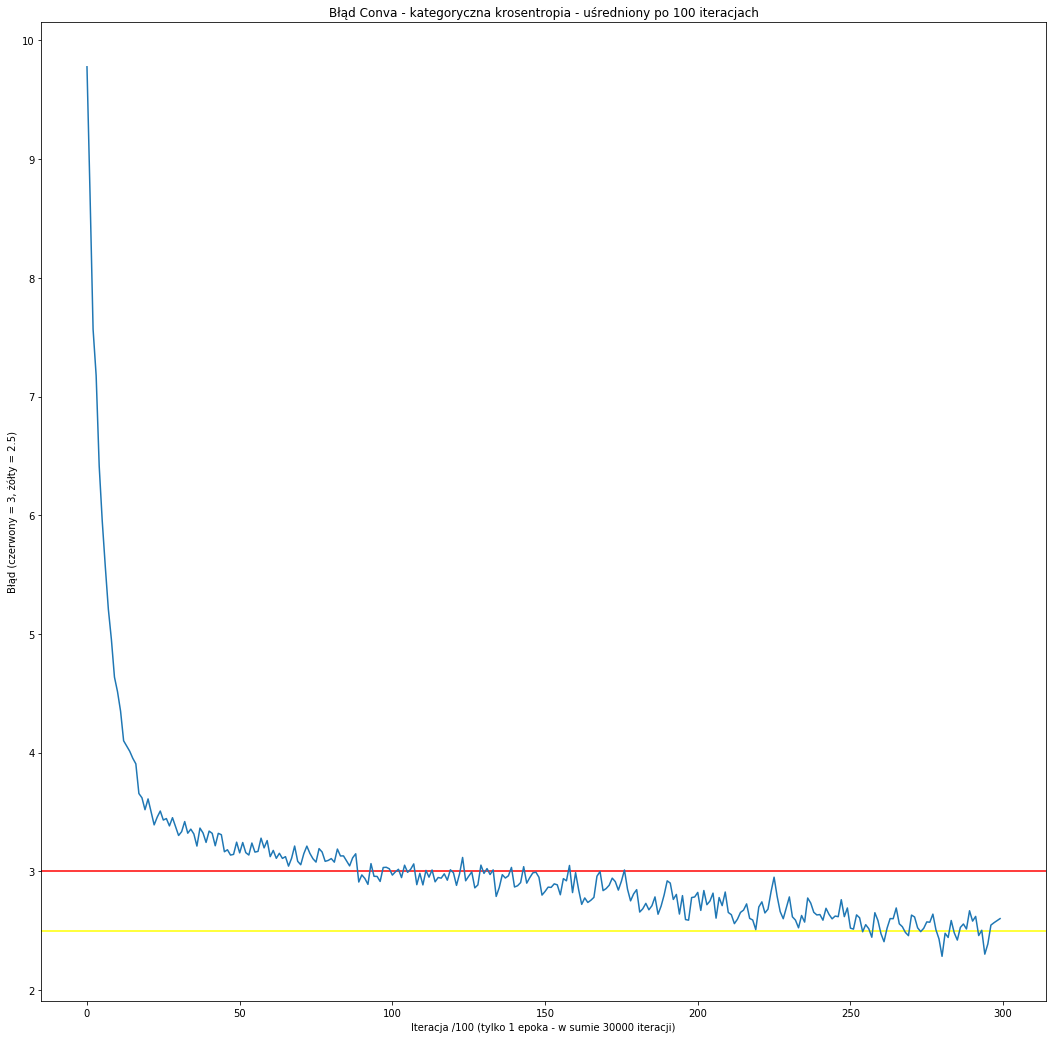

In [56]:
print(w2.shape)
fig, ax=plt.subplots(1, 1, figsize=(18,18))
dt=loopz
kgbo=100
dt2=dt//kgbo

dkkk=[0]*dt2
for i in range(dt2):
    dkkk[i]=sum(sk[i*kgbo:(i+1)*kgbo])/kgbo

ax.set_title('Błąd Conva - kategoryczna krosentropia - uśredniony po {} iteracjach'.format(kgbo))
ax.set_xlabel('Iteracja /100 (tylko 1 epoka - w sumie {} iteracji)'.format(loopz))
ax.set_ylabel('Błąd (czerwony = 3, żółty = 2.5)'.format(loopz))
ax.axhline(3, color='red')
ax.axhline(2.5, color='yellow')
ax.plot(dkkk)
plt.show()

In [43]:
num=3000
won=0

for jj in range(num):
    img=testX[jj]
    img=img/255
    img=img.reshape(img.shape[0], img.shape[1], 1)
    """img1=img.copy()
    img=np.append(img, img1, axis=2)
    img=np.append(img, img1, axis=2)"""

    m2=[0]*10
    m3=[0]*10
    m4=[0]*10
    m8=[0]*10
    #Forw - Konwolucja, Relu, Pooling
    for i in range(10):
        m2[i]=conv_forw(img, matt[i])
        m3[i]=relu(m2[i])
        m4[i], Face1=pool_forw(m3[i], (2,2))
        m8[i]=m4[i].reshape(m4[i].shape[0]*m4[i].shape[1]*m4[i].shape[2])

    """m5=[0]*10
    m6=[0]*10
    m7=[0]*10
    #Forw - Konwolucja, Relu, Pooling
    for i in range(10):
        m5[i]=conv_forw(m4[i], matt2[i]) 
        m6[i]=relu(m5[i])
        m7[i], Face2=pool_forw(m6[i], (2,2))
        m8[i]=m7[i].reshape(m7[i].shape[0]*m7[i].shape[1]*m7[i].shape[2])"""


    #Forw - 2*FC na macierzach
    kk=np.asarray(m8)
    m9=np.asmatrix(kk.reshape(kk.shape[0]*kk.shape[1], 1))
    #print(len(m9))

    s1=w1*m9
    s2=sigmoid_forw(s1)
    s3=w2*s2
    s4=sigmoid_forw(s3)

    #Koszt
    dp=np.asarray([0]*10).reshape(10, 1)
    dp[testy[jj],0]=1
    der, suma=cost(dp, s4)
    mxi=0
    for i in range(10):
        if (s4[i,0]>s4[mxi,0]):
            mxi=i
    if (mxi==testy[jj]):
        won+=1    
    #print(mxi, testy[jj])
print('Skutecznosc na {} testach: {}'.format(num, won/num))

Skutecznosc na 3000 testach: 0.544


In [32]:
##Od tego miejsca śmieci do debugu
###
###
###


k1=np.asarray([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]])
k1=k1.reshape(k1.shape[0], k1.shape[1], 1)
mathr=np.asarray([[1,2,3],[-1,-2,-3],[-10,10,20]])
c1=conv_forw(k1, mathr)
#c1=c1.reshape(c1.shape[0], c1.shape[1])
kgb=pool_forw(k1, (2,2))

print(kgb[1].reshape(kgb[1].shape[0], kgb[1].shape[1]))


[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]
 [0. 1. 0. 1.]]


In [139]:
dkk=[0]*10
for i in range(100):
    dkk[testy[i]]+=1
print(dkk)


#print(kk[3:kk.shape[0]-4,1:kk.shape[1]-2].shape)
#print(print(kk[3:kk.shape[0]-4,1:kk.shape[1]-2]))
#print(z)
#TT=(kk[3:kk.shape[0]-4,1:kk.shape[1]-2]==z)
#print(TT[TT==False])

[8, 14, 8, 11, 14, 7, 10, 15, 2, 11]


(1048, 698, 3) (7, 7)
2 2
(1050, 705, 3) (7, 7)
(150, 100)
150 100


In [17]:
mat=mymat
Y=np.ndarray((z.shape[0]*mat.shape[0], z.shape[1]*mat.shape[1]*3, z.shape[2]*2), dtype='float64')
t1=time.time()
for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
        for ij in range(z.shape[2]):
            Y[i:i+1,j,ij]=1
t2=time.time()
print(t2-t1)
print(Y.shape[0]*Y.shape[1]*Y.shape[2])

7.269612789154053
29625912


In [10]:
k=[random.random() for i in range(10)]
print(k)

[0.5984270187569013, 0.9671677742926911, 0.7976401137331915, 0.053760428992956966, 0.25749371422047285, 0.16253284123891132, 0.9060344103299387, 0.2756248627348449, 0.5445703657707015, 0.39006604163079217]


In [ ]:
z=cv2.imread("E:\W3\GGHard.jpg")
#z=z/255
mymat=np.asarray([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
z=conv_forw(z, mymat)
z=relu(z)
t1=time.time()
z, dt=pool_forw(z,(7,7))
t2=time.time()
print(t2-t1)
print(dt.shape)
#z=pool(z,(7,7))

"""fig, ax=plt.subplots(1,1,figsize=(20,20))
ax.imshow(z)
ax.axis('off')
plt.show()"""

In [ ]:
def conv_forw(X, mat):
    Z=np.ndarray((X.shape[0]-mat.shape[0]+1, X.shape[1]-mat.shape[1]+1, X.shape[2]), dtype='int64')
    Z=Z*0
    print(type(X))
    X=X.astype('int64')
    
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ff=mat[i,j]*X
            ff=ff[i:X.shape[0]-mat.shape[0]+i+1,j:X.shape[1]-mat.shape[1]+j+1]
            Z=Z+ff
    return Z

def conv_forw2(X, mat):
    Z=np.ndarray((X.shape[0]-mat.shape[0]+1, X.shape[1]-mat.shape[1]+1, X.shape[2]), dtype='int64')
    Z=Z*0
    print(type(X))
    X=X.astype('int64')    
    
    print(Z.shape[0]*Z.shape[1]*mat.shape[0]*mat.shape[0])
    xz1=mat.shape[0]
    xz2=mat.shape[1]
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            ii=0
            while (ii<xz1):
                jj=0
                while(jj<xz2):
                    Z[i,j]=1
                    jj+=1
                ii+=1
    return Z
            
B=np.asarray([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
kurl=r"E:\W3\GGHard.jpg"
kk=cv2.imread(kurl)

t1=time.time()
nightmare=conv_forw2(kk, B)
t2=time.time()
print(t2-t1)
t1=time.time()
nightmare2 = ndimage.convolve(kk.astype('int64'), B.reshape(3,3,1))
t2=time.time()
print(t2-t1)

fig, ax=plt.subplots(1,2,figsize=(22,22))
ax[0].imshow(nightmare2)
ax[0].axis('off')
ax[1].imshow(nightmare)
ax[1].axis('off')
plt.show()

In [ ]:
print(kk.shape)
print(nightmare2[1:nightmare2.shape[0]-1,1:nightmare2.shape[1]-1])
print(nightmare)

def relu(x):
    if (x<0):
        return 0
    return x

def pool_forward(X):
    Y=pd.Series([True]*X.shape[0])
    Y2=pd.Series([True]*X.shape[1])
    
    Y[Y.index%2==0]=False
    Y2[Y2.index%2==0]=False 
    KK1=X[Y][:,Y2]
    KK2=X[Y][:,~Y2]
    KK3=X[~Y][:,Y2]
    KK4=X[~Y][:,~Y2]
    
    Dt=KK1*0+1
    Exit=KK1
    Dt[Exit<KK2]=2
    Exit[Exit<KK2]=KK2[Exit<KK2]
    Dt[Exit<KK3]=3
    Exit[Exit<KK3]=KK3[Exit<KK3]
    Dt[Exit<KK4]=4
    Exit[Exit<KK4]=KK3[Exit<KK4]
    
    return (Dt, KK1)

t1=time.time()
Res, KK=pool_forward(nightmare)
t2=time.time()
print(t2-t1)

print(nightmare[:4,:4,0])

#Dodanie wersetu w 2 wymiarze
print(KK.shape)
s=[0]*KK.shape[0]*KK.shape[2]
s=np.asarray(s).reshape(KK.shape[0], 1, 3)
GG=np.append(KK, s, axis=1)
print(GG.shape)

In [98]:
n1, n2 = np.arange(5), np.arange(5)
Y=m7[0]
n1=np.arange(m7[0].shape[0])

f1=pd.Series([1]*Y.shape[0])
f2=pd.Series([1]*Y.shape[1])
f3=pd.Series([1]*Y.shape[2])

n1=np.asarray(f1[(f1.index%2)==0].index)
n2=np.asarray(f2[(f2.index%2)==1].index)
n3=np.asarray(f3.index)

m7[0][n1,n2]=13
print(m7[0][np.ix_(n1, n2,n3)].shape)
print(m7[0].shape)

(3, 3, 3)
(6, 6, 3)


In [119]:
print(math.exp(-100000))

0.0
